# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Machine Learning com Python e C++</font>
## <font color='blue'>Projeto 4 - Precificação de Ativos Financeiros com Risco Condicional</font>

![title](imagens/projeto4.png)

## Definição do Problema

Leia o manual em pdf no Capítulo 6 do curso.

## Instalando Pacotes Para Manipulação de Dados

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Imports
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy     : 1.16.6
sklearn   : 0.21.0
pandas    : 1.2.0
matplotlib: 3.1.3
scipy     : 1.2.1
seaborn   : 0.11.1



## Construindo a Arquitetura do Modelo

http://www.deeplearningbook.com.br/ (Capítulos de 1 a 39)

![title](imagens/imagem1.png)

## Dense Layer (Camada Densa)

A saída de cada camada é a transformação da saída das camadas anteriores. 

Estamos tentando maximizar a probabilidade de forma equivalente tentando minimizar a probabilidade logarítmica negativa. Assim, atualizamos os parâmetros da rede com derivadas parciais da função de perda com relação a cada parâmetro. Escalamos por uma taxa de aprendizagem para evitar que o gradiente salte e não se acomode nos mínimos locais mais baixos possíveis.

Para obter os gradientes da função de perda, usamos a regra da cadeia (chain rule):

$$\frac{\partial L}{\partial x_i} = \sum_j \frac{\partial L}{\partial y_j}\frac{\partial y_j}{\partial x_i}$$

Uma vez que cada entrada de uma determinada camada é saída da anterior, podemos armazenar a derivada de entrada de cada camada e transferi-la para a camada anterior durante o backpropagation.

Usando a regra da cadeia, obtemos as fórmulas necessárias que precisamos para atualizar os parâmetros da rede.

Considerando a camada de saída, os gradientes de que precisamos:

***Derivada em relação à entrada (input):***
$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \omega^T$$

***Derivada em relação à matriz de peso:***
$$\frac{\partial L}{\partial \omega} = X^T \frac{\partial L}{\partial Y}$$

***Derivada em relação ao vetor de polarização (bias):***
$$\frac{\partial L}{\partial B} = \frac{\partial L}{\partial Y}$$

A classe abaixo implementa uma camada totalmente conectada (Densa):

- O método Forward refere-se à operação linear que produz saída que será transferida para a função de ativação que corresponderá à próxima camada.
 
 
- O método backward refere-se a backpropagation, que toma a derivada da função de perda em relação à saída da camada como argumento, calcula as derivadas em relação à sua própria entrada e pesos, atualiza seus pesos e vieses e, em seguida, retorna a derivada da função de perda em relação à sua própria entrada

In [4]:
# Classe para a camada densa
class Dense:
    
    # Método construtor
    def __init__(self, feat_size, out_size):
        self.feat_size = feat_size
        self.out_size = out_size
        self.weights = (np.random.normal(0, 1, feat_size * out_size) * np.sqrt(2 / feat_size)).reshape(feat_size, out_size)
        self.bias = np.random.rand(1, out_size) - 0.5

    # Método da passada linear para frente
    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return(self.output)

    # Método da passada de volta (backpropagation)
    def backward(self, output_der, lr): 
        input_der = np.dot(output_der, self.weights.T)
        weight_der = np.dot(self.input.T.reshape(-1, 1), output_der)
        self.weights -= lr * weight_der
        self.bias -= lr * output_der
        return(input_der)

## Função de Ativação

Em vez de implementar a função de ativação dentro da camada densa, a implementação como camada separada simplifica o backpropagation. Esta camada não atualizará nenhum parâmetro, apenas retornará a derivada da função de perda em relação à função de ativação para a camada anterior totalmente conectada.

Na passagem para a frente, a camada de ativação pegará a saída da camada densa e a transferirá após a aplicação da função ReLu.

In [5]:
# Função de ativação
def relu(x):  
    return(np.maximum(0, x))

In [6]:
# Derivada da função de ativação
def relu_prime(x):  
    x[x > 0] = 1
    x[x <= 0] = 0  
    return x

In [7]:
# Classe da camada de ativação
class ActLayer:
    
    # Método construtor
    def __init__(self, act, act_prime):
        self.act = act
        self.act_prime = act_prime

    # Recebe a entrada (input) e retorna a saída da função de ativação
    def forward(self, input_data):
        self.input = input_data
        self.output = self.act(self.input)
        return(self.output)

    # Observe que não estamos atualizando nenhum parâmetro aqui
    # Usamos a taxa de aprendizagem como parâmetro porque definiremos o método de ajuste de uma forma 
    # que todas as camadas o exigirão.
    def backward(self, output_der, lr):
        return(self.act_prime(self.input) * output_der)

## Função de Perda e Derivada

Diversas funções de perda podem ser usadas dependendo se o modelo é de classificação ou regressão. Aqui usaremos a função mais comum em regressão, a MSE.

In [8]:
# Usaremos a Mean-Squared-Error como função de perda
def mse(y_true, y_pred):
    return(np.mean((y_pred - y_true)**2))

In [9]:
# Derivada da função de perda
def mse_prime(y_true, y_pred):
    return(2*(y_pred - y_true) / y_true.size)

## Classe Final do Modelo

Observe que fazemos o loop nas camadas em ordem reversa.

In [10]:
# Modelo
class Network:
    
    # Método construtor
    # Inicializa com a função de perda e sua derivada
    def __init__(self, loss, loss_prime):  
        self.layers = []  
        self.loss = loss
        self.loss_prime = loss_prime

    # Método para adicionar camadas ao grafo computacional
    def add(self, layer):
        self.layers.append(layer)

    # Implementando apenas forward-pass para predição
    def predict(self, input_data):
        
        # Lista para o resultado
        result = [] 

        for a in range(len(input_data)):
            
            # Camada de saída
            layer_output = input_data[a]
            
            # Loop pelas camadas
            for layer in self.layers:
                
                # Movendo vetores de camada para camada
                layer_output = layer.forward(layer_output)
                
            result.append(layer_output)

        return(result)

    # Método de treinamento
    def fit(self, X_train, y_train, epochs, lr):

        # Número de iterações
        for a in range(epochs):  
            
            # Inicializa a variável de cálculo do erro
            err = 0

            # Temos 1 passagem para a frente e para trás para cada ponto de dados 
            # Esse algoritmo de aprendizagem usa a Descida Estocástica do Gradiente
            for j in range(len(X_train)):
                
                # Camada de saída
                layer_output = X_train[j]
                
                # Loop pelas camadas
                for layer in self.layers:
                    layer_output = layer.forward(layer_output)

                # Vamos guardar o erro e mostrar durante o treinamento
                err += self.loss(y_train[j], layer_output)

                # Observe que fazemos o loop nas camadas em ordem reversa.
                # Inicialmente calculamos a derivada da perda com relação à previsão.
                # Em seguida, a camada de saída irá calcular a derivada em relação à sua entrada
                # e irá passar esta derivada de entrada para a camada anterior que corresponde à sua derivada de saída
                # e essa camada repetirá o mesmo processo, passando sua derivada de entrada para a camada anterior.

                # dL/dY_hat
                gradient = self.loss_prime(y_train[j], layer_output)  
                
                # Este loop é a razão de termos dado lr à camada de ativação como argumento
                for layer in reversed(self.layers):
                    
                    # Definindo gradiente para dY / dh_ {i + 1} da camada atual
                    gradient = layer.backward(gradient, lr)

            err /= len(X_train)
            
            print('Epoch %d/%d   Erro = %f' % (a + 1, epochs, err))

## Vamos Testar o Modelo Resolvendo o XOR (Ou Exclusivo da Lógica Computacional)

In [11]:
# Dados
x_train = np.array([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# Ajuste dos dados
x_train = x_train.reshape(-1, 2)
y_train = y_train.reshape(-1, 1)

# Modelo
modelo_xor = Network(mse, mse_prime)
modelo_xor.add(Dense(2, 3))
modelo_xor.add(ActLayer(relu, relu_prime))
modelo_xor.add(Dense(3, 1))

# Treinamento
modelo_xor.fit(x_train, y_train, epochs = 2000, lr = 0.01)

# Teste
y_pred = modelo_xor.predict(x_train)

Epoch 1/2000   Erro = 7.972762
Epoch 2/2000   Erro = 3.186805
Epoch 3/2000   Erro = 1.767855
Epoch 4/2000   Erro = 1.133073
Epoch 5/2000   Erro = 0.798892
Epoch 6/2000   Erro = 0.605380
Epoch 7/2000   Erro = 0.486010
Epoch 8/2000   Erro = 0.408905
Epoch 9/2000   Erro = 0.365515
Epoch 10/2000   Erro = 0.344667
Epoch 11/2000   Erro = 0.327535
Epoch 12/2000   Erro = 0.313995
Epoch 13/2000   Erro = 0.303213
Epoch 14/2000   Erro = 0.294433
Epoch 15/2000   Erro = 0.287122
Epoch 16/2000   Erro = 0.280901
Epoch 17/2000   Erro = 0.275498
Epoch 18/2000   Erro = 0.270717
Epoch 19/2000   Erro = 0.266413
Epoch 20/2000   Erro = 0.262482
Epoch 21/2000   Erro = 0.258845
Epoch 22/2000   Erro = 0.255444
Epoch 23/2000   Erro = 0.252236
Epoch 24/2000   Erro = 0.249187
Epoch 25/2000   Erro = 0.246272
Epoch 26/2000   Erro = 0.243471
Epoch 27/2000   Erro = 0.239566
Epoch 28/2000   Erro = 0.238525
Epoch 29/2000   Erro = 0.235974
Epoch 30/2000   Erro = 0.233501
Epoch 31/2000   Erro = 0.233757
Epoch 32/2000   E

Epoch 309/2000   Erro = 0.052151
Epoch 310/2000   Erro = 0.051223
Epoch 311/2000   Erro = 0.050687
Epoch 312/2000   Erro = 0.050111
Epoch 313/2000   Erro = 0.049540
Epoch 314/2000   Erro = 0.048972
Epoch 315/2000   Erro = 0.048408
Epoch 316/2000   Erro = 0.048489
Epoch 317/2000   Erro = 0.047681
Epoch 318/2000   Erro = 0.046938
Epoch 319/2000   Erro = 0.046573
Epoch 320/2000   Erro = 0.046019
Epoch 321/2000   Erro = 0.045469
Epoch 322/2000   Erro = 0.044924
Epoch 323/2000   Erro = 0.045126
Epoch 324/2000   Erro = 0.044130
Epoch 325/2000   Erro = 0.043663
Epoch 326/2000   Erro = 0.043127
Epoch 327/2000   Erro = 0.042596
Epoch 328/2000   Erro = 0.042069
Epoch 329/2000   Erro = 0.041547
Epoch 330/2000   Erro = 0.041831
Epoch 331/2000   Erro = 0.040822
Epoch 332/2000   Erro = 0.040344
Epoch 333/2000   Erro = 0.039830
Epoch 334/2000   Erro = 0.039322
Epoch 335/2000   Erro = 0.038819
Epoch 336/2000   Erro = 0.038929
Epoch 337/2000   Erro = 0.038119
Epoch 338/2000   Erro = 0.037665
Epoch 339/

Epoch 625/2000   Erro = 0.000414
Epoch 626/2000   Erro = 0.000405
Epoch 627/2000   Erro = 0.000397
Epoch 628/2000   Erro = 0.000402
Epoch 629/2000   Erro = 0.000388
Epoch 630/2000   Erro = 0.000380
Epoch 631/2000   Erro = 0.000372
Epoch 632/2000   Erro = 0.000364
Epoch 633/2000   Erro = 0.000365
Epoch 634/2000   Erro = 0.000356
Epoch 635/2000   Erro = 0.000348
Epoch 636/2000   Erro = 0.000341
Epoch 637/2000   Erro = 0.000334
Epoch 638/2000   Erro = 0.000327
Epoch 639/2000   Erro = 0.000330
Epoch 640/2000   Erro = 0.000320
Epoch 641/2000   Erro = 0.000313
Epoch 642/2000   Erro = 0.000306
Epoch 643/2000   Erro = 0.000300
Epoch 644/2000   Erro = 0.000294
Epoch 645/2000   Erro = 0.000299
Epoch 646/2000   Erro = 0.000287
Epoch 647/2000   Erro = 0.000281
Epoch 648/2000   Erro = 0.000275
Epoch 649/2000   Erro = 0.000270
Epoch 650/2000   Erro = 0.000271
Epoch 651/2000   Erro = 0.000263
Epoch 652/2000   Erro = 0.000258
Epoch 653/2000   Erro = 0.000252
Epoch 654/2000   Erro = 0.000247
Epoch 655/

Epoch 942/2000   Erro = 0.000001
Epoch 943/2000   Erro = 0.000001
Epoch 944/2000   Erro = 0.000001
Epoch 945/2000   Erro = 0.000001
Epoch 946/2000   Erro = 0.000001
Epoch 947/2000   Erro = 0.000001
Epoch 948/2000   Erro = 0.000001
Epoch 949/2000   Erro = 0.000001
Epoch 950/2000   Erro = 0.000001
Epoch 951/2000   Erro = 0.000001
Epoch 952/2000   Erro = 0.000001
Epoch 953/2000   Erro = 0.000001
Epoch 954/2000   Erro = 0.000001
Epoch 955/2000   Erro = 0.000001
Epoch 956/2000   Erro = 0.000001
Epoch 957/2000   Erro = 0.000001
Epoch 958/2000   Erro = 0.000001
Epoch 959/2000   Erro = 0.000001
Epoch 960/2000   Erro = 0.000001
Epoch 961/2000   Erro = 0.000001
Epoch 962/2000   Erro = 0.000001
Epoch 963/2000   Erro = 0.000001
Epoch 964/2000   Erro = 0.000001
Epoch 965/2000   Erro = 0.000001
Epoch 966/2000   Erro = 0.000001
Epoch 967/2000   Erro = 0.000001
Epoch 968/2000   Erro = 0.000001
Epoch 969/2000   Erro = 0.000001
Epoch 970/2000   Erro = 0.000001
Epoch 971/2000   Erro = 0.000001
Epoch 972/

Epoch 1256/2000   Erro = 0.000000
Epoch 1257/2000   Erro = 0.000000
Epoch 1258/2000   Erro = 0.000000
Epoch 1259/2000   Erro = 0.000000
Epoch 1260/2000   Erro = 0.000000
Epoch 1261/2000   Erro = 0.000000
Epoch 1262/2000   Erro = 0.000000
Epoch 1263/2000   Erro = 0.000000
Epoch 1264/2000   Erro = 0.000000
Epoch 1265/2000   Erro = 0.000000
Epoch 1266/2000   Erro = 0.000000
Epoch 1267/2000   Erro = 0.000000
Epoch 1268/2000   Erro = 0.000000
Epoch 1269/2000   Erro = 0.000000
Epoch 1270/2000   Erro = 0.000000
Epoch 1271/2000   Erro = 0.000000
Epoch 1272/2000   Erro = 0.000000
Epoch 1273/2000   Erro = 0.000000
Epoch 1274/2000   Erro = 0.000000
Epoch 1275/2000   Erro = 0.000000
Epoch 1276/2000   Erro = 0.000000
Epoch 1277/2000   Erro = 0.000000
Epoch 1278/2000   Erro = 0.000000
Epoch 1279/2000   Erro = 0.000000
Epoch 1280/2000   Erro = 0.000000
Epoch 1281/2000   Erro = 0.000000
Epoch 1282/2000   Erro = 0.000000
Epoch 1283/2000   Erro = 0.000000
Epoch 1284/2000   Erro = 0.000000
Epoch 1285/200

Epoch 1571/2000   Erro = 0.000000
Epoch 1572/2000   Erro = 0.000000
Epoch 1573/2000   Erro = 0.000000
Epoch 1574/2000   Erro = 0.000000
Epoch 1575/2000   Erro = 0.000000
Epoch 1576/2000   Erro = 0.000000
Epoch 1577/2000   Erro = 0.000000
Epoch 1578/2000   Erro = 0.000000
Epoch 1579/2000   Erro = 0.000000
Epoch 1580/2000   Erro = 0.000000
Epoch 1581/2000   Erro = 0.000000
Epoch 1582/2000   Erro = 0.000000
Epoch 1583/2000   Erro = 0.000000
Epoch 1584/2000   Erro = 0.000000
Epoch 1585/2000   Erro = 0.000000
Epoch 1586/2000   Erro = 0.000000
Epoch 1587/2000   Erro = 0.000000
Epoch 1588/2000   Erro = 0.000000
Epoch 1589/2000   Erro = 0.000000
Epoch 1590/2000   Erro = 0.000000
Epoch 1591/2000   Erro = 0.000000
Epoch 1592/2000   Erro = 0.000000
Epoch 1593/2000   Erro = 0.000000
Epoch 1594/2000   Erro = 0.000000
Epoch 1595/2000   Erro = 0.000000
Epoch 1596/2000   Erro = 0.000000
Epoch 1597/2000   Erro = 0.000000
Epoch 1598/2000   Erro = 0.000000
Epoch 1599/2000   Erro = 0.000000
Epoch 1600/200

Epoch 1812/2000   Erro = 0.000000
Epoch 1813/2000   Erro = 0.000000
Epoch 1814/2000   Erro = 0.000000
Epoch 1815/2000   Erro = 0.000000
Epoch 1816/2000   Erro = 0.000000
Epoch 1817/2000   Erro = 0.000000
Epoch 1818/2000   Erro = 0.000000
Epoch 1819/2000   Erro = 0.000000
Epoch 1820/2000   Erro = 0.000000
Epoch 1821/2000   Erro = 0.000000
Epoch 1822/2000   Erro = 0.000000
Epoch 1823/2000   Erro = 0.000000
Epoch 1824/2000   Erro = 0.000000
Epoch 1825/2000   Erro = 0.000000
Epoch 1826/2000   Erro = 0.000000
Epoch 1827/2000   Erro = 0.000000
Epoch 1828/2000   Erro = 0.000000
Epoch 1829/2000   Erro = 0.000000
Epoch 1830/2000   Erro = 0.000000
Epoch 1831/2000   Erro = 0.000000
Epoch 1832/2000   Erro = 0.000000
Epoch 1833/2000   Erro = 0.000000
Epoch 1834/2000   Erro = 0.000000
Epoch 1835/2000   Erro = 0.000000
Epoch 1836/2000   Erro = 0.000000
Epoch 1837/2000   Erro = 0.000000
Epoch 1838/2000   Erro = 0.000000
Epoch 1839/2000   Erro = 0.000000
Epoch 1840/2000   Erro = 0.000000
Epoch 1841/200

In [12]:
print("Valor Real:", "\n",
      list(y_train.reshape(-1,)), "\n",
      "------------", "\n",
      "Valor Previsto:", "\n",
      [round(float(a)) for a in y_pred])

Valor Real: 
 [0, 1, 1, 0] 
 ------------ 
 Valor Previsto: 
 [0, 1, 1, 0]


## Precificação de Ativos Financeiros com Risco Condicional

## Gerando Preços de Ações

O modelo Black Scholes, também conhecido como modelo Black-Scholes-Merton (BSM), é um modelo matemático para precificar um contrato de opções (ações de empresas). Em particular, o modelo estima a variação ao longo do tempo de instrumentos financeiros. Ele pressupõe esses instrumentos (como ações ou futuros) terão uma distribuição lognormal de preços. Usando essa suposição e levando em consideração outras variáveis importantes, a equação deriva o preço de uma opção de compra.

O modelo assume que o preço dos ativos fortemente negociados segue um movimento browniano geométrico com flutuação e volatilidade constantes. Quando aplicado a uma opção de ações, o modelo incorpora a variação constante do preço da ação, o valor do dinheiro no tempo, o preço de exercício da opção e o tempo para o vencimento da opção, criando assim um risco condicional para o investimento.

Também chamado de Black-Scholes-Merton, foi o primeiro modelo amplamente utilizado para precificação de opções. É utilizado para calcular o valor teórico das opções usando os preços atuais das ações, dividendos esperados, preço de exercício da opção, taxas de juros esperadas, prazo de vencimento e expectativa volatilidade.

A fórmula, desenvolvida por três economistas - Fischer Black, Myron Scholes e Robert Merton - é talvez o modelo de precificação de opções mais conhecido do mundo. A equação inicial foi introduzida no artigo de Black and Scholes de 1973, "The Pricing of Options and Corporate Liability", publicado no Journal of Political Economy. Black faleceu dois anos antes de Scholes e Merton receberem o Prêmio Nobel de Economia de 1997 por seu trabalho na descoberta de um novo método para determinar o valor dos derivados (o Prêmio Nobel não é concedido postumamente; no entanto, o comitê do Nobel reconheceu o papel de Black no modelo Black-Scholes).

Referências:

https://www.investopedia.com/terms/b/blackscholes.asp

***Equação diferencial estocástica de Black e Scholes para preços de ações:***

$$dS_t = S_0(\sigma dB_t + rdt)$$

***A solução é dada por:***

$$S_t = S_0e^{\sigma(B_t - B_0) + (r - \frac{1}{2}\sigma^2)t}$$

***Discretizando:***

$$log(S_t) - log(S_0) = \sigma N(0, t) + (r - \frac{1}{2}\sigma^2)t$$

***$B_t$*** : Brownian Motion

***$S_i$*** : Stock price at time i

***$r$*** : Risk Free rate

***$\sigma$*** : Predicted Volatility, taken as constant for simplecity

***Equação diferencial parcial de Black e Scholes para preços de opções:***

$$rF(t, S_t) = \frac{\partial F}{\partial t}(t, S_t) + rS_t\frac{\partial F}{\partial x}(t, S_t) + \frac{1}{2}\sigma^2 S_t^2\frac{F}{x^2}(t, S_t)$$

***A solução é dada por:***

$$C_0 = S_0\mathcal{N}(d_1) - e^{-rT}K\mathcal{N}(d_2)$$

A solução pode ser obtida de 2 maneiras: 

- Primeiro usando a abordagem da árvore bionomial, indo do caso discreto para o contínuo. 

- Segundo resolvendo o PDE por várias mudanças de variáveis, então obtemos a equação.

Mais detalhes, consulte:

Primeiro caso: Cox-Rubinstein, OPTION PRICING: A SIMPLIFIED APPROACH

Segundo caso: Black-Scholes The Pricing of options and Corporate Liabilities.

## Prepara as variáveis

In [13]:
# Volatility (standard deviation), sigma de SDE e PDE
vol = 0.17 

In [14]:
# Maturity
T = 1/2 

In [15]:
#  Número de etapas que usamos para discretizar o processo acima
n = 1000

In [16]:
# O preço inicial do estoque corresponde a S_0 nas funções acima
s_0 = 100  

In [17]:
#  Taxa livre de risco, termo que deriva de SDE -> r
r = 0.05  

In [18]:
# Preço de exercício da opção -> K
k = 100 

## Funções de Cálculo Para Geração de Dados

In [19]:
def calculate_spot(prev, sigma, r, step, random):
    return(prev + (sigma*prev*random) + (r*prev*step))

In [20]:
def sim_spot(s0, r, steps, maturity, vol):
    delta_t = T/steps
    time = np.round(np.arange(0, maturity+delta_t, delta_t), 4)  
    prices = [s0]
    normal_dist = np.random.normal(0, np.sqrt(delta_t), 10000)
    for a in range(steps):
        prices.append(calculate_spot(prices[-1], vol, r, delta_t, normal_dist[a]))
    return(prices)

In [21]:
# Gerando 5 caminhos diferentes para testar as funções
# Vamos usar apenas 1 caminho no treinamento de rede
sims = pd.DataFrame()
for a in range(5):
    sims[a] = sim_spot(s_0, r, n, T, vol)

In [22]:
# Valores para simulações
sims.columns = ["Sim_1", "Sim_2", "Sim_3", "Sim_4", "Sim_5"]
sims.index = np.round(np.arange(0, 0.5 + (0.5 / 1000), 0.5 / 1000), 4)

[Text(0, 0.5, 'Preços dos Ativos'),
 Text(0.5, 0, 'Passos'),
 Text(0.5, 1.0, 'Simulações')]

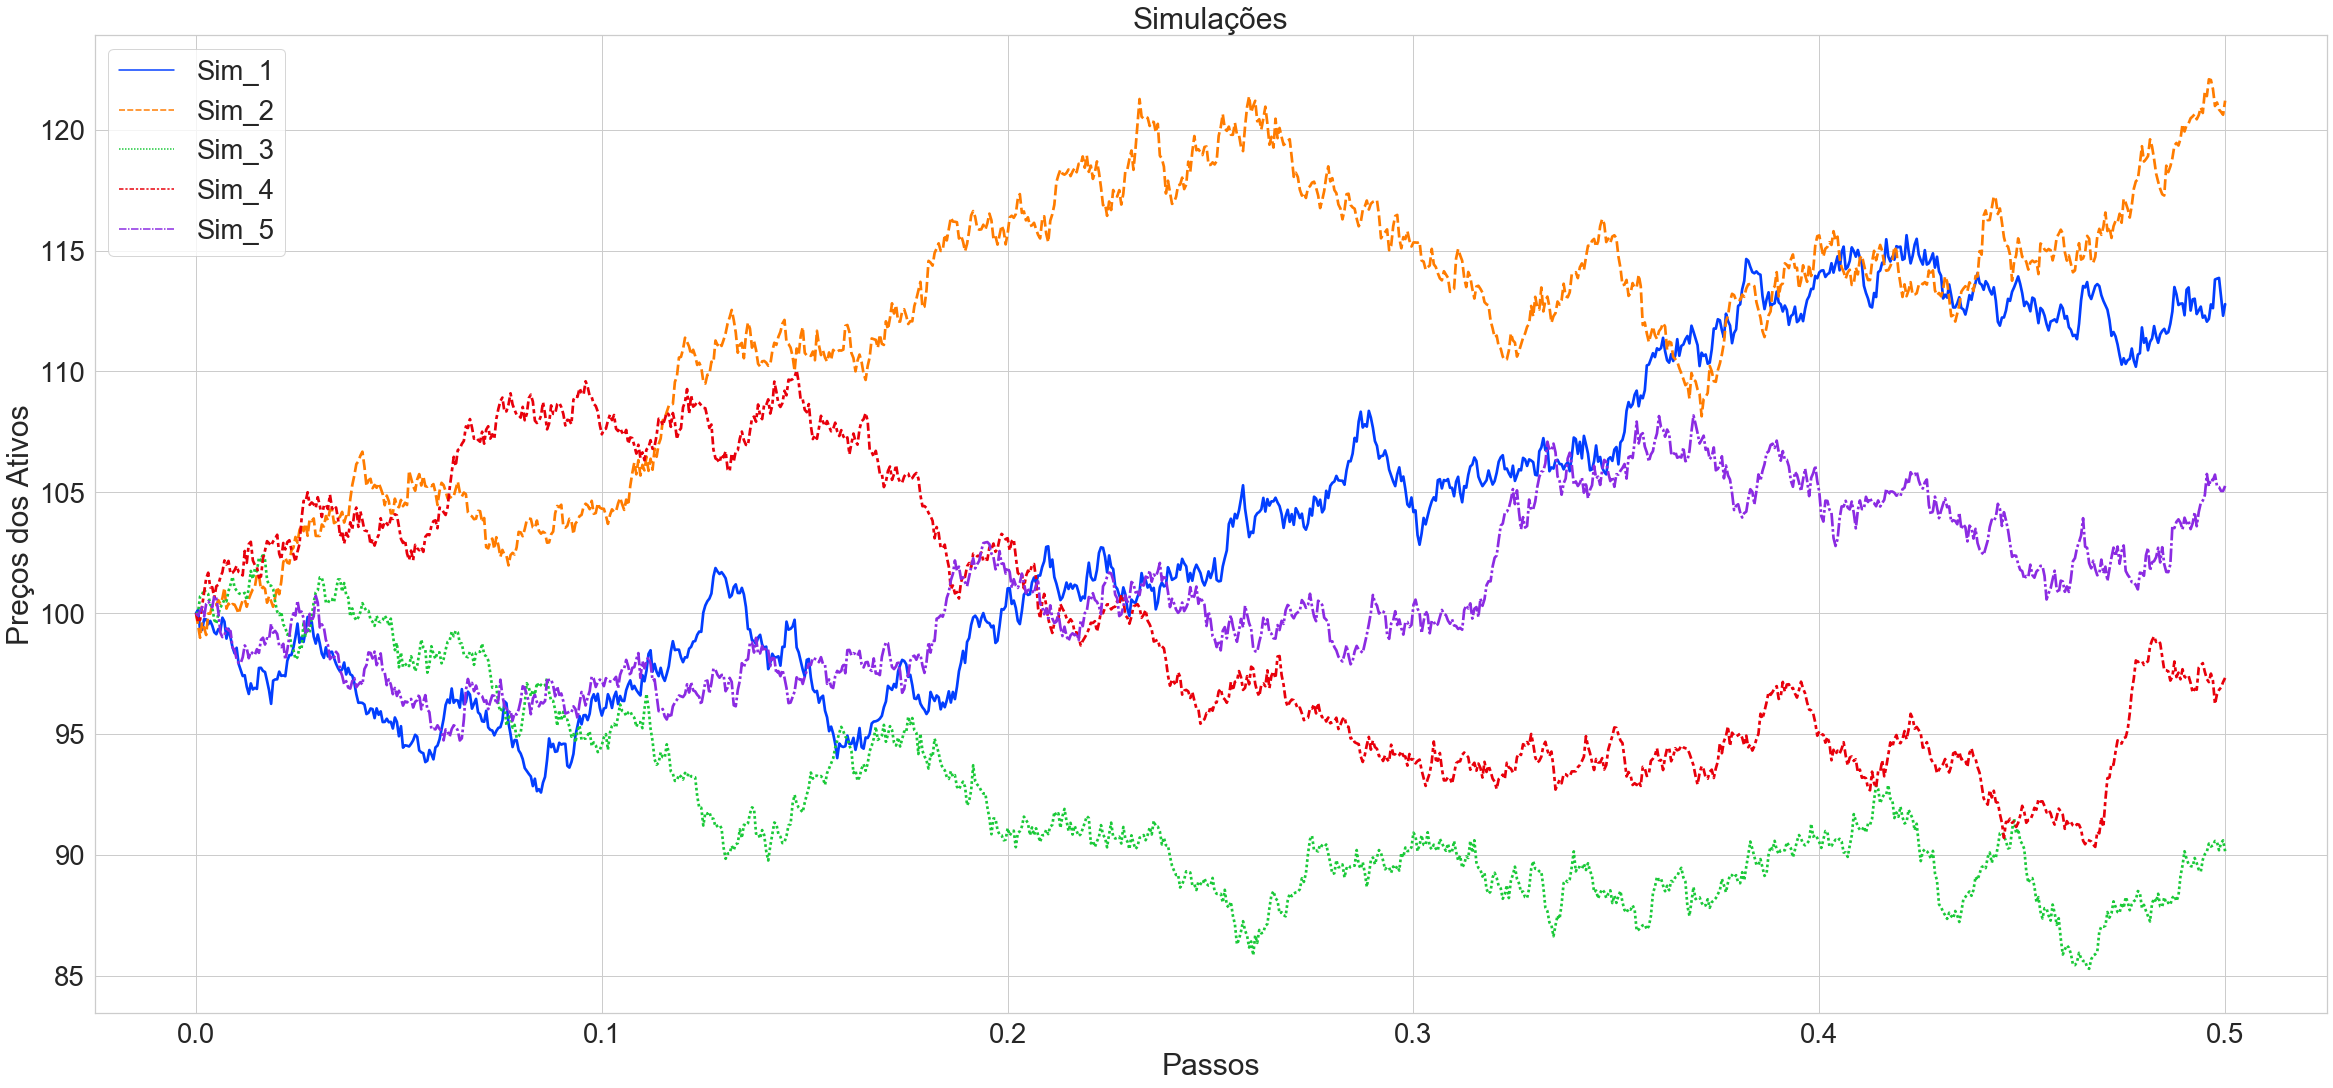

In [23]:
sns.set(style = "whitegrid", font_scale = 2.5)
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = sims, palette = "bright", linewidth = 2.7)
ax.set(xlabel = 'Passos', ylabel = 'Preços dos Ativos', title = "Simulações")

## Preparando os Preços Finais

In [24]:
def d1(s, k, r, t, T, vol): 
    if T != t:
        nomin = np.log(s/k) + (r + 0.5*(vol**2))*(T-t)
        denom = vol*np.sqrt((T-t))
        return(nomin/denom)
    else:
        None


def d2(s, k, r, t, T, vol): 
    if T != t:
        nomin = np.log(s/k) + (r - 0.5*(vol**2))*(T-t)
        denom = vol*np.sqrt((T-t))
        return(nomin/denom)
    else:
        None


def call(d1, d2, k, r, T, t, s):
    return(s*scipy.stats.norm.cdf(d1) - k*np.exp(-r*(T-t))*scipy.stats.norm.cdf(d2))

In [25]:
call_prices = []
maturity = []
for (a, b) in zip(sims["Sim_1"], sims.index):
    if b != T:
        d1_ = d1(a, k, r, b, T, vol)
        d2_ = d2(a, k, r, b, T, vol)
        call_prices.append(call(d1_, d2_, k, r, T, b, a))
        maturity.append((T-b))
    else:
        call_prices.append(max(a-k, 0))
        maturity.append(0)

In [26]:
# Dataframe dos preços
opt_price = pd.DataFrame(call_prices, sims.index)
opt_price = opt_price.rename(columns = {0: "Sim_1_Call"})
opt_price = pd.concat([opt_price, sims["Sim_1"]], axis = 1)
min_max = MinMaxScaler(feature_range=(min(call_prices), max(call_prices)))
opt_price["Sim_1_scaled"] = min_max.fit_transform(opt_price["Sim_1"].values.reshape(-1, 1))
opt_price.index = pd.date_range(start = '01/01/2018', end = '06/01/2018', periods = 1001)

[Text(0, 0.5, 'Preços dos Ativos'),
 Text(0.5, 0, 'Data'),
 Text(0.5, 1.0, 'Preço da Ação - Valor de Venda da Ação')]

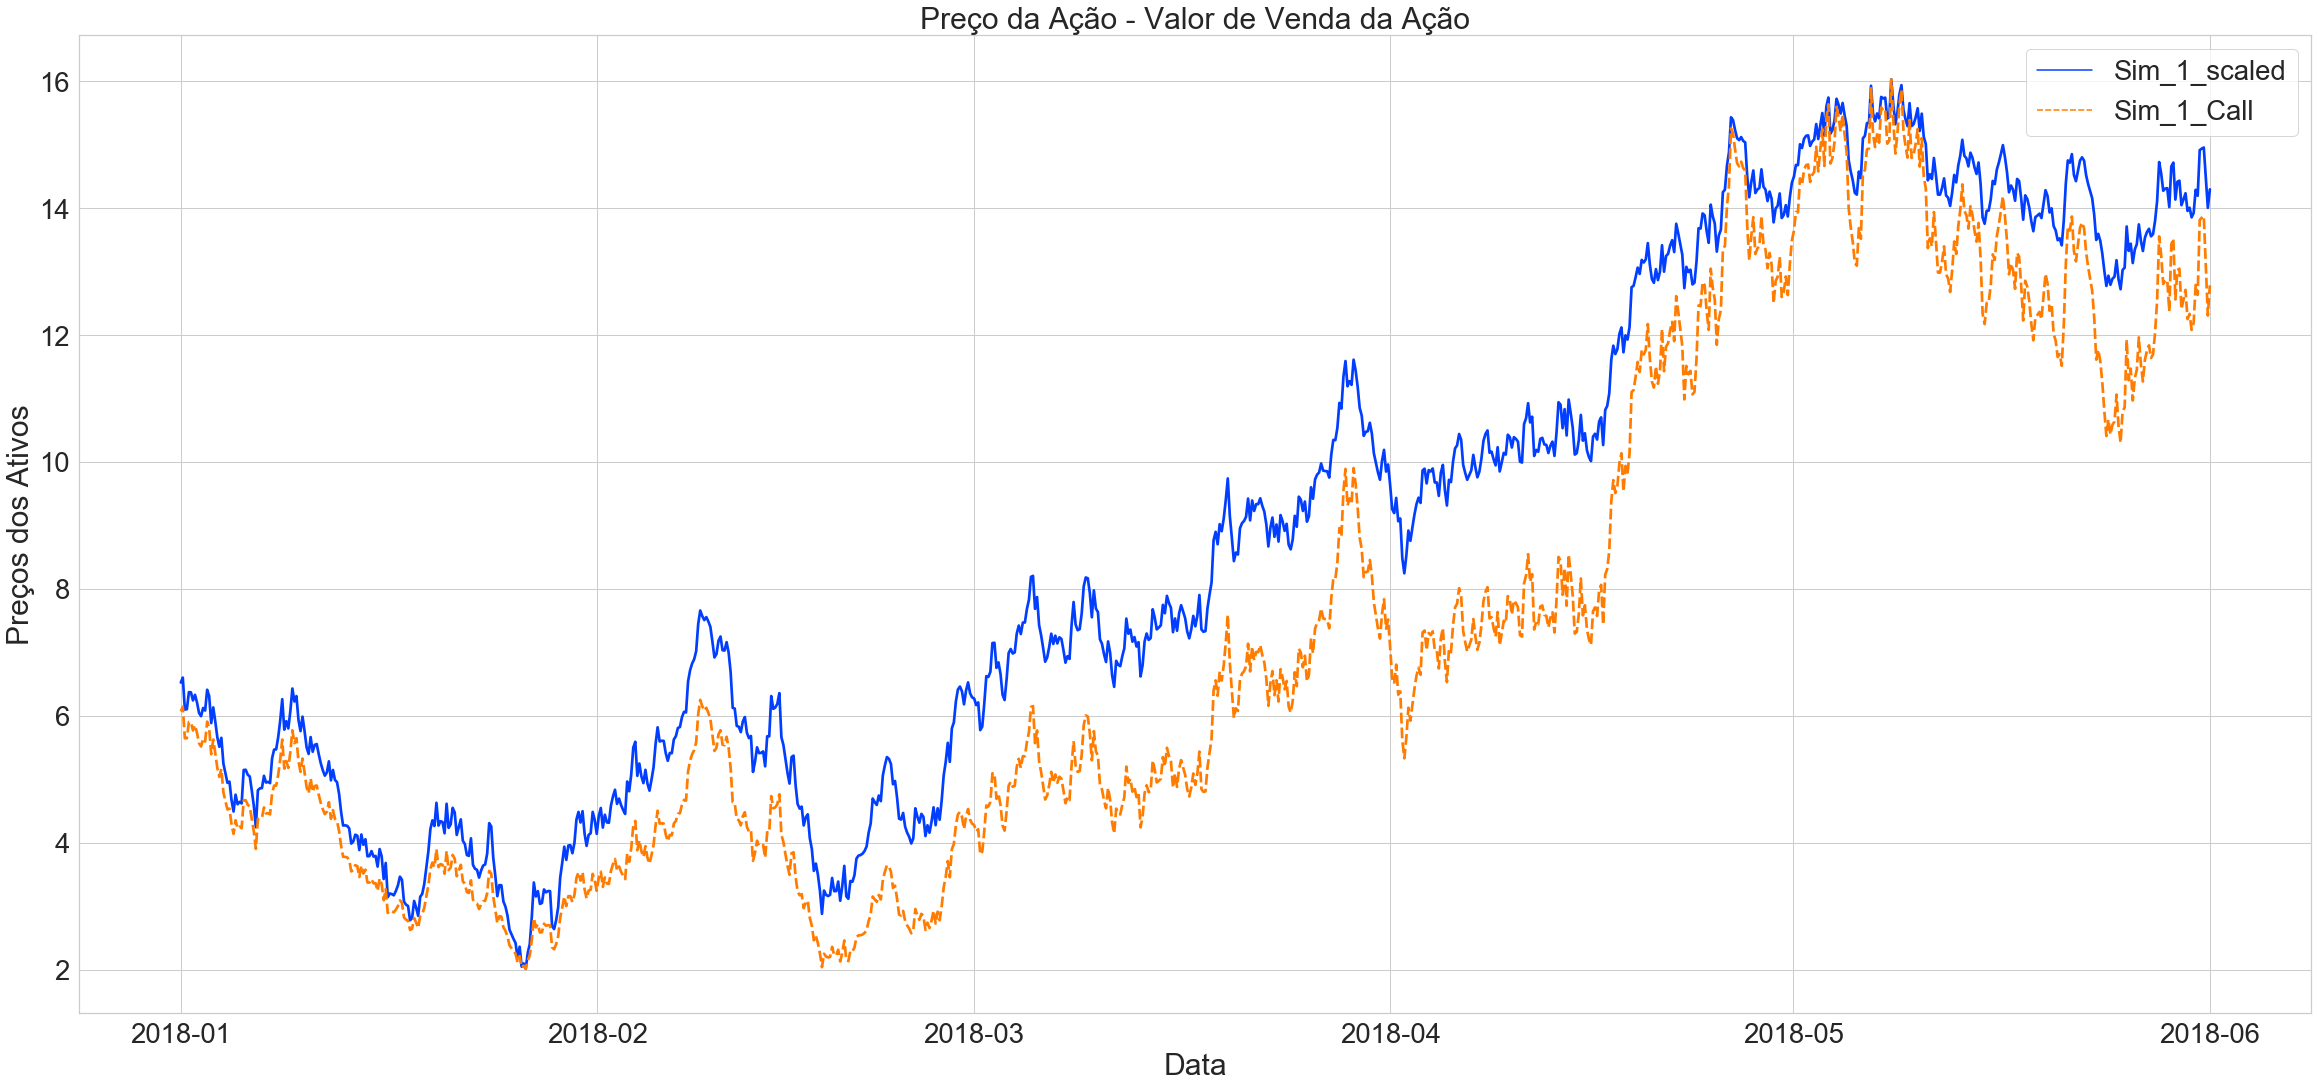

In [27]:
sns.set(style = "whitegrid", font_scale=2.5)
plt.figure(figsize=(40, 18))
ax = sns.lineplot(data = opt_price[["Sim_1_scaled", "Sim_1_Call"]], palette = "bright", linewidth = 2.7)
ax.set(xlabel = 'Data', ylabel = 'Preços dos Ativos', title = "Preço da Ação - Valor de Venda da Ação")

## Preparação de Dados Para Treinamento

In [28]:
# Dataframe final
opt_price["Maturity"] = maturity
opt_price["Strike"] = k
opt_price["Risk_Free"] = r
opt_price["Volatility"] = vol
model_data = opt_price.drop(["Sim_1_scaled"], axis = 1)

In [29]:
# Visualiza
model_data.head()

,Sim_1_Call,Sim_1,Maturity,Strike,Risk_Free,Volatility
2018-01-01 00:00:00.000,6.069936,100.000000,0.5000,100,0.05,0.17
2018-01-01 03:37:26.400,6.144115,100.128119,0.4995,100,0.05,0.17
2018-01-01 07:14:52.800,5.646865,99.300474,0.4990,100,0.05,0.17
2018-01-01 10:52:19.200,5.648092,99.308820,0.4985,100,0.05,0.17
2018-01-01 14:29:45.600,5.905465,99.751012,0.4980,100,0.05,0.17


In [30]:
# Dados de treino e teste
train_data = model_data.iloc[:round(len(model_data) * 0.8)]  
test_data = model_data.iloc[len(train_data):]

In [31]:
X_train = train_data.drop(["Sim_1_Call"], axis = 1).values
y_train = train_data["Sim_1_Call"].values

X_test = test_data.drop(["Sim_1_Call"], axis = 1).values
y_test = test_data["Sim_1_Call"].values

min_max = MinMaxScaler()

X_train = min_max.fit_transform(X_train)
X_test = min_max.transform(X_test)

print("X_train shape:", X_train.shape, "\n",
      "y_train shape:", y_train.shape, "\n",
      "X_test shape:", X_test.shape, "\n",
      "y_test shape:", y_test.shape)

X_train shape: (801, 5) 
 y_train shape: (801,) 
 X_test shape: (200, 5) 
 y_test shape: (200,)


## Treinamento

***Treinando Por 10 Epochs***

In [32]:
%%time

# Treinando Por 10 Epochs

# Modelo
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

# Treinamento
model.fit(X_train, y_train, epochs = 10, lr = 0.001)

# Previsões
y_pred_10 = model.predict(X_test)
y_pred_10 = [float(a) for a in y_pred_10]

Epoch 1/10   Erro = 0.096305
Epoch 2/10   Erro = 0.333803
Epoch 3/10   Erro = 0.110715
Epoch 4/10   Erro = 0.032248
Epoch 5/10   Erro = 0.023537
Epoch 6/10   Erro = 0.035165
Epoch 7/10   Erro = 0.035844
Epoch 8/10   Erro = 0.029200
Epoch 9/10   Erro = 0.023128
Epoch 10/10   Erro = 0.018587
CPU times: user 24.1 s, sys: 10.4 s, total: 34.5 s
Wall time: 4.58 s


***Treinando Por 100 Epochs***

In [33]:
%%time

# Treinando Por 100 Epochs

# Modelo
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

# Treinamento
model.fit(X_train, y_train, epochs = 100, lr = 0.001)

# Previsões
y_pred_100 = model.predict(X_test)
y_pred_100 = [float(a) for a in y_pred_100]

Epoch 1/100   Erro = 0.107121
Epoch 2/100   Erro = 0.179388
Epoch 3/100   Erro = 0.055378
Epoch 4/100   Erro = 0.017060
Epoch 5/100   Erro = 0.013272
Epoch 6/100   Erro = 0.019105
Epoch 7/100   Erro = 0.021031
Epoch 8/100   Erro = 0.018714
Epoch 9/100   Erro = 0.015973
Epoch 10/100   Erro = 0.013335
Epoch 11/100   Erro = 0.010939
Epoch 12/100   Erro = 0.009010
Epoch 13/100   Erro = 0.007654
Epoch 14/100   Erro = 0.006502
Epoch 15/100   Erro = 0.005748
Epoch 16/100   Erro = 0.005015
Epoch 17/100   Erro = 0.004527
Epoch 18/100   Erro = 0.004107
Epoch 19/100   Erro = 0.003812
Epoch 20/100   Erro = 0.003607
Epoch 21/100   Erro = 0.003432
Epoch 22/100   Erro = 0.003259
Epoch 23/100   Erro = 0.003181
Epoch 24/100   Erro = 0.003100
Epoch 25/100   Erro = 0.002986
Epoch 26/100   Erro = 0.002911
Epoch 27/100   Erro = 0.002831
Epoch 28/100   Erro = 0.002795
Epoch 29/100   Erro = 0.002707
Epoch 30/100   Erro = 0.002651
Epoch 31/100   Erro = 0.002603
Epoch 32/100   Erro = 0.002515
Epoch 33/100   Er

***Treinando Por 200 Epochs***

In [34]:
%%time

# Treinando Por 200 Epochs

# Modelo
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

# Treinamento
model.fit(X_train, y_train, epochs = 200, lr = 0.001)

# Previsões
y_pred_200 = model.predict(X_test)
y_pred_200 = [float(a) for a in y_pred_200]

Epoch 1/200   Erro = 0.096243
Epoch 2/200   Erro = 0.191165
Epoch 3/200   Erro = 0.053715
Epoch 4/200   Erro = 0.017582
Epoch 5/200   Erro = 0.024877
Epoch 6/200   Erro = 0.031369
Epoch 7/200   Erro = 0.029074
Epoch 8/200   Erro = 0.023901
Epoch 9/200   Erro = 0.019618
Epoch 10/200   Erro = 0.016085
Epoch 11/200   Erro = 0.013225
Epoch 12/200   Erro = 0.010814
Epoch 13/200   Erro = 0.009625
Epoch 14/200   Erro = 0.008231
Epoch 15/200   Erro = 0.007447
Epoch 16/200   Erro = 0.006864
Epoch 17/200   Erro = 0.006371
Epoch 18/200   Erro = 0.006092
Epoch 19/200   Erro = 0.005802
Epoch 20/200   Erro = 0.005525
Epoch 21/200   Erro = 0.005271
Epoch 22/200   Erro = 0.005174
Epoch 23/200   Erro = 0.004887
Epoch 24/200   Erro = 0.004754
Epoch 25/200   Erro = 0.004595
Epoch 26/200   Erro = 0.004422
Epoch 27/200   Erro = 0.004279
Epoch 28/200   Erro = 0.004132
Epoch 29/200   Erro = 0.003966
Epoch 30/200   Erro = 0.003821
Epoch 31/200   Erro = 0.003709
Epoch 32/200   Erro = 0.003578
Epoch 33/200   Er

***Treinando Por 1000 Epochs***

In [35]:
%%time

# Treinando Por 1000 Epochs

# Modelo
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

# Treinamento
model.fit(X_train, y_train, epochs = 1000, lr = 0.001)

# Previsões
y_pred_1k = model.predict(X_test)
y_pred_1k = [float(a) for a in y_pred_1k]

Epoch 1/1000   Erro = 0.159850
Epoch 2/1000   Erro = 0.257429
Epoch 3/1000   Erro = 0.084747
Epoch 4/1000   Erro = 0.026878
Epoch 5/1000   Erro = 0.011334
Epoch 6/1000   Erro = 0.016643
Epoch 7/1000   Erro = 0.021216
Epoch 8/1000   Erro = 0.020195
Epoch 9/1000   Erro = 0.016821
Epoch 10/1000   Erro = 0.013549
Epoch 11/1000   Erro = 0.010734
Epoch 12/1000   Erro = 0.008457
Epoch 13/1000   Erro = 0.006646
Epoch 14/1000   Erro = 0.005277
Epoch 15/1000   Erro = 0.004267
Epoch 16/1000   Erro = 0.003539
Epoch 17/1000   Erro = 0.003069
Epoch 18/1000   Erro = 0.002706
Epoch 19/1000   Erro = 0.002485
Epoch 20/1000   Erro = 0.002327
Epoch 21/1000   Erro = 0.002259
Epoch 22/1000   Erro = 0.002214
Epoch 23/1000   Erro = 0.002182
Epoch 24/1000   Erro = 0.002186
Epoch 25/1000   Erro = 0.002172
Epoch 26/1000   Erro = 0.002149
Epoch 27/1000   Erro = 0.002102
Epoch 28/1000   Erro = 0.002093
Epoch 29/1000   Erro = 0.002034
Epoch 30/1000   Erro = 0.002012
Epoch 31/1000   Erro = 0.001975
Epoch 32/1000   E

Epoch 253/1000   Erro = 0.000186
Epoch 254/1000   Erro = 0.000186
Epoch 255/1000   Erro = 0.000187
Epoch 256/1000   Erro = 0.000185
Epoch 257/1000   Erro = 0.000184
Epoch 258/1000   Erro = 0.000183
Epoch 259/1000   Erro = 0.000183
Epoch 260/1000   Erro = 0.000183
Epoch 261/1000   Erro = 0.000183
Epoch 262/1000   Erro = 0.000181
Epoch 263/1000   Erro = 0.000181
Epoch 264/1000   Erro = 0.000179
Epoch 265/1000   Erro = 0.000181
Epoch 266/1000   Erro = 0.000180
Epoch 267/1000   Erro = 0.000178
Epoch 268/1000   Erro = 0.000177
Epoch 269/1000   Erro = 0.000177
Epoch 270/1000   Erro = 0.000176
Epoch 271/1000   Erro = 0.000176
Epoch 272/1000   Erro = 0.000175
Epoch 273/1000   Erro = 0.000175
Epoch 274/1000   Erro = 0.000175
Epoch 275/1000   Erro = 0.000173
Epoch 276/1000   Erro = 0.000174
Epoch 277/1000   Erro = 0.000174
Epoch 278/1000   Erro = 0.000173
Epoch 279/1000   Erro = 0.000174
Epoch 280/1000   Erro = 0.000173
Epoch 281/1000   Erro = 0.000172
Epoch 282/1000   Erro = 0.000173
Epoch 283/

Epoch 502/1000   Erro = 0.000111
Epoch 503/1000   Erro = 0.000111
Epoch 504/1000   Erro = 0.000111
Epoch 505/1000   Erro = 0.000110
Epoch 506/1000   Erro = 0.000110
Epoch 507/1000   Erro = 0.000110
Epoch 508/1000   Erro = 0.000110
Epoch 509/1000   Erro = 0.000110
Epoch 510/1000   Erro = 0.000110
Epoch 511/1000   Erro = 0.000109
Epoch 512/1000   Erro = 0.000110
Epoch 513/1000   Erro = 0.000109
Epoch 514/1000   Erro = 0.000109
Epoch 515/1000   Erro = 0.000108
Epoch 516/1000   Erro = 0.000108
Epoch 517/1000   Erro = 0.000108
Epoch 518/1000   Erro = 0.000108
Epoch 519/1000   Erro = 0.000109
Epoch 520/1000   Erro = 0.000108
Epoch 521/1000   Erro = 0.000107
Epoch 522/1000   Erro = 0.000107
Epoch 523/1000   Erro = 0.000106
Epoch 524/1000   Erro = 0.000106
Epoch 525/1000   Erro = 0.000107
Epoch 526/1000   Erro = 0.000108
Epoch 527/1000   Erro = 0.000107
Epoch 528/1000   Erro = 0.000107
Epoch 529/1000   Erro = 0.000107
Epoch 530/1000   Erro = 0.000107
Epoch 531/1000   Erro = 0.000107
Epoch 532/

Epoch 751/1000   Erro = 0.000078
Epoch 752/1000   Erro = 0.000079
Epoch 753/1000   Erro = 0.000078
Epoch 754/1000   Erro = 0.000078
Epoch 755/1000   Erro = 0.000079
Epoch 756/1000   Erro = 0.000079
Epoch 757/1000   Erro = 0.000078
Epoch 758/1000   Erro = 0.000078
Epoch 759/1000   Erro = 0.000078
Epoch 760/1000   Erro = 0.000078
Epoch 761/1000   Erro = 0.000078
Epoch 762/1000   Erro = 0.000077
Epoch 763/1000   Erro = 0.000077
Epoch 764/1000   Erro = 0.000078
Epoch 765/1000   Erro = 0.000077
Epoch 766/1000   Erro = 0.000077
Epoch 767/1000   Erro = 0.000077
Epoch 768/1000   Erro = 0.000078
Epoch 769/1000   Erro = 0.000077
Epoch 770/1000   Erro = 0.000077
Epoch 771/1000   Erro = 0.000077
Epoch 772/1000   Erro = 0.000077
Epoch 773/1000   Erro = 0.000077
Epoch 774/1000   Erro = 0.000077
Epoch 775/1000   Erro = 0.000077
Epoch 776/1000   Erro = 0.000077
Epoch 777/1000   Erro = 0.000076
Epoch 778/1000   Erro = 0.000076
Epoch 779/1000   Erro = 0.000076
Epoch 780/1000   Erro = 0.000077
Epoch 781/

Epoch 1000/1000   Erro = 0.000059
CPU times: user 37min 29s, sys: 15min 36s, total: 53min 5s
Wall time: 7min


***Treinando Por 5000 Epochs***

In [36]:
%%time

# Treinando Por 5000 Epochs

# Modelo
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

# Treinamento
model.fit(X_train, y_train, epochs = 5000, lr = 0.001)

# Previsões
y_pred_5k = model.predict(X_test)
y_pred_5k = [float(a) for a in y_pred_5k]

Epoch 1/5000   Erro = 0.138543
Epoch 2/5000   Erro = 0.158190
Epoch 3/5000   Erro = 0.045489
Epoch 4/5000   Erro = 0.014829
Epoch 5/5000   Erro = 0.018571
Epoch 6/5000   Erro = 0.025494
Epoch 7/5000   Erro = 0.024667
Epoch 8/5000   Erro = 0.020995
Epoch 9/5000   Erro = 0.017153
Epoch 10/5000   Erro = 0.013727
Epoch 11/5000   Erro = 0.011346
Epoch 12/5000   Erro = 0.009604
Epoch 13/5000   Erro = 0.008529
Epoch 14/5000   Erro = 0.007634
Epoch 15/5000   Erro = 0.007114
Epoch 16/5000   Erro = 0.006727
Epoch 17/5000   Erro = 0.006607
Epoch 18/5000   Erro = 0.006425
Epoch 19/5000   Erro = 0.006233
Epoch 20/5000   Erro = 0.006047
Epoch 21/5000   Erro = 0.005888
Epoch 22/5000   Erro = 0.005764
Epoch 23/5000   Erro = 0.005555
Epoch 24/5000   Erro = 0.005447
Epoch 25/5000   Erro = 0.005319
Epoch 26/5000   Erro = 0.005150
Epoch 27/5000   Erro = 0.005113
Epoch 28/5000   Erro = 0.004855
Epoch 29/5000   Erro = 0.004690
Epoch 30/5000   Erro = 0.004537
Epoch 31/5000   Erro = 0.004469
Epoch 32/5000   E

Epoch 253/5000   Erro = 0.000511
Epoch 254/5000   Erro = 0.000502
Epoch 255/5000   Erro = 0.000497
Epoch 256/5000   Erro = 0.000507
Epoch 257/5000   Erro = 0.000490
Epoch 258/5000   Erro = 0.000497
Epoch 259/5000   Erro = 0.000511
Epoch 260/5000   Erro = 0.000501
Epoch 261/5000   Erro = 0.000493
Epoch 262/5000   Erro = 0.000484
Epoch 263/5000   Erro = 0.000485
Epoch 264/5000   Erro = 0.000498
Epoch 265/5000   Erro = 0.000479
Epoch 266/5000   Erro = 0.000494
Epoch 267/5000   Erro = 0.000474
Epoch 268/5000   Erro = 0.000487
Epoch 269/5000   Erro = 0.000469
Epoch 270/5000   Erro = 0.000488
Epoch 271/5000   Erro = 0.000473
Epoch 272/5000   Erro = 0.000466
Epoch 273/5000   Erro = 0.000466
Epoch 274/5000   Erro = 0.000462
Epoch 275/5000   Erro = 0.000465
Epoch 276/5000   Erro = 0.000456
Epoch 277/5000   Erro = 0.000461
Epoch 278/5000   Erro = 0.000455
Epoch 279/5000   Erro = 0.000457
Epoch 280/5000   Erro = 0.000454
Epoch 281/5000   Erro = 0.000454
Epoch 282/5000   Erro = 0.000449
Epoch 283/

Epoch 502/5000   Erro = 0.000288
Epoch 503/5000   Erro = 0.000295
Epoch 504/5000   Erro = 0.000288
Epoch 505/5000   Erro = 0.000294
Epoch 506/5000   Erro = 0.000286
Epoch 507/5000   Erro = 0.000295
Epoch 508/5000   Erro = 0.000289
Epoch 509/5000   Erro = 0.000292
Epoch 510/5000   Erro = 0.000288
Epoch 511/5000   Erro = 0.000294
Epoch 512/5000   Erro = 0.000286
Epoch 513/5000   Erro = 0.000292
Epoch 514/5000   Erro = 0.000284
Epoch 515/5000   Erro = 0.000291
Epoch 516/5000   Erro = 0.000285
Epoch 517/5000   Erro = 0.000294
Epoch 518/5000   Erro = 0.000284
Epoch 519/5000   Erro = 0.000291
Epoch 520/5000   Erro = 0.000285
Epoch 521/5000   Erro = 0.000289
Epoch 522/5000   Erro = 0.000284
Epoch 523/5000   Erro = 0.000290
Epoch 524/5000   Erro = 0.000281
Epoch 525/5000   Erro = 0.000287
Epoch 526/5000   Erro = 0.000279
Epoch 527/5000   Erro = 0.000284
Epoch 528/5000   Erro = 0.000289
Epoch 529/5000   Erro = 0.000282
Epoch 530/5000   Erro = 0.000285
Epoch 531/5000   Erro = 0.000281
Epoch 532/

Epoch 751/5000   Erro = 0.000174
Epoch 752/5000   Erro = 0.000176
Epoch 753/5000   Erro = 0.000173
Epoch 754/5000   Erro = 0.000176
Epoch 755/5000   Erro = 0.000175
Epoch 756/5000   Erro = 0.000170
Epoch 757/5000   Erro = 0.000176
Epoch 758/5000   Erro = 0.000175
Epoch 759/5000   Erro = 0.000173
Epoch 760/5000   Erro = 0.000170
Epoch 761/5000   Erro = 0.000172
Epoch 762/5000   Erro = 0.000173
Epoch 763/5000   Erro = 0.000170
Epoch 764/5000   Erro = 0.000174
Epoch 765/5000   Erro = 0.000172
Epoch 766/5000   Erro = 0.000170
Epoch 767/5000   Erro = 0.000174
Epoch 768/5000   Erro = 0.000170
Epoch 769/5000   Erro = 0.000173
Epoch 770/5000   Erro = 0.000171
Epoch 771/5000   Erro = 0.000173
Epoch 772/5000   Erro = 0.000172
Epoch 773/5000   Erro = 0.000171
Epoch 774/5000   Erro = 0.000168
Epoch 775/5000   Erro = 0.000170
Epoch 776/5000   Erro = 0.000168
Epoch 777/5000   Erro = 0.000171
Epoch 778/5000   Erro = 0.000172
Epoch 779/5000   Erro = 0.000166
Epoch 780/5000   Erro = 0.000170
Epoch 781/

Epoch 1000/5000   Erro = 0.000122
Epoch 1001/5000   Erro = 0.000119
Epoch 1002/5000   Erro = 0.000121
Epoch 1003/5000   Erro = 0.000121
Epoch 1004/5000   Erro = 0.000118
Epoch 1005/5000   Erro = 0.000121
Epoch 1006/5000   Erro = 0.000120
Epoch 1007/5000   Erro = 0.000118
Epoch 1008/5000   Erro = 0.000118
Epoch 1009/5000   Erro = 0.000120
Epoch 1010/5000   Erro = 0.000121
Epoch 1011/5000   Erro = 0.000116
Epoch 1012/5000   Erro = 0.000119
Epoch 1013/5000   Erro = 0.000119
Epoch 1014/5000   Erro = 0.000117
Epoch 1015/5000   Erro = 0.000117
Epoch 1016/5000   Erro = 0.000117
Epoch 1017/5000   Erro = 0.000115
Epoch 1018/5000   Erro = 0.000116
Epoch 1019/5000   Erro = 0.000117
Epoch 1020/5000   Erro = 0.000114
Epoch 1021/5000   Erro = 0.000116
Epoch 1022/5000   Erro = 0.000116
Epoch 1023/5000   Erro = 0.000113
Epoch 1024/5000   Erro = 0.000115
Epoch 1025/5000   Erro = 0.000114
Epoch 1026/5000   Erro = 0.000115
Epoch 1027/5000   Erro = 0.000114
Epoch 1028/5000   Erro = 0.000112
Epoch 1029/500

Epoch 1241/5000   Erro = 0.000091
Epoch 1242/5000   Erro = 0.000092
Epoch 1243/5000   Erro = 0.000090
Epoch 1244/5000   Erro = 0.000091
Epoch 1245/5000   Erro = 0.000091
Epoch 1246/5000   Erro = 0.000089
Epoch 1247/5000   Erro = 0.000090
Epoch 1248/5000   Erro = 0.000089
Epoch 1249/5000   Erro = 0.000090
Epoch 1250/5000   Erro = 0.000091
Epoch 1251/5000   Erro = 0.000089
Epoch 1252/5000   Erro = 0.000089
Epoch 1253/5000   Erro = 0.000087
Epoch 1254/5000   Erro = 0.000087
Epoch 1255/5000   Erro = 0.000089
Epoch 1256/5000   Erro = 0.000089
Epoch 1257/5000   Erro = 0.000089
Epoch 1258/5000   Erro = 0.000088
Epoch 1259/5000   Erro = 0.000088
Epoch 1260/5000   Erro = 0.000088
Epoch 1261/5000   Erro = 0.000090
Epoch 1262/5000   Erro = 0.000089
Epoch 1263/5000   Erro = 0.000088
Epoch 1264/5000   Erro = 0.000089
Epoch 1265/5000   Erro = 0.000087
Epoch 1266/5000   Erro = 0.000089
Epoch 1267/5000   Erro = 0.000086
Epoch 1268/5000   Erro = 0.000087
Epoch 1269/5000   Erro = 0.000088
Epoch 1270/500

Epoch 1482/5000   Erro = 0.000069
Epoch 1483/5000   Erro = 0.000068
Epoch 1484/5000   Erro = 0.000069
Epoch 1485/5000   Erro = 0.000068
Epoch 1486/5000   Erro = 0.000069
Epoch 1487/5000   Erro = 0.000068
Epoch 1488/5000   Erro = 0.000068
Epoch 1489/5000   Erro = 0.000068
Epoch 1490/5000   Erro = 0.000067
Epoch 1491/5000   Erro = 0.000069
Epoch 1492/5000   Erro = 0.000067
Epoch 1493/5000   Erro = 0.000067
Epoch 1494/5000   Erro = 0.000068
Epoch 1495/5000   Erro = 0.000068
Epoch 1496/5000   Erro = 0.000068
Epoch 1497/5000   Erro = 0.000067
Epoch 1498/5000   Erro = 0.000066
Epoch 1499/5000   Erro = 0.000068
Epoch 1500/5000   Erro = 0.000068
Epoch 1501/5000   Erro = 0.000068
Epoch 1502/5000   Erro = 0.000066
Epoch 1503/5000   Erro = 0.000065
Epoch 1504/5000   Erro = 0.000066
Epoch 1505/5000   Erro = 0.000066
Epoch 1506/5000   Erro = 0.000067
Epoch 1507/5000   Erro = 0.000066
Epoch 1508/5000   Erro = 0.000066
Epoch 1509/5000   Erro = 0.000066
Epoch 1510/5000   Erro = 0.000066
Epoch 1511/500

Epoch 1723/5000   Erro = 0.000054
Epoch 1724/5000   Erro = 0.000054
Epoch 1725/5000   Erro = 0.000054
Epoch 1726/5000   Erro = 0.000053
Epoch 1727/5000   Erro = 0.000054
Epoch 1728/5000   Erro = 0.000055
Epoch 1729/5000   Erro = 0.000054
Epoch 1730/5000   Erro = 0.000054
Epoch 1731/5000   Erro = 0.000054
Epoch 1732/5000   Erro = 0.000054
Epoch 1733/5000   Erro = 0.000054
Epoch 1734/5000   Erro = 0.000053
Epoch 1735/5000   Erro = 0.000053
Epoch 1736/5000   Erro = 0.000053
Epoch 1737/5000   Erro = 0.000053
Epoch 1738/5000   Erro = 0.000053
Epoch 1739/5000   Erro = 0.000054
Epoch 1740/5000   Erro = 0.000054
Epoch 1741/5000   Erro = 0.000053
Epoch 1742/5000   Erro = 0.000053
Epoch 1743/5000   Erro = 0.000053
Epoch 1744/5000   Erro = 0.000052
Epoch 1745/5000   Erro = 0.000052
Epoch 1746/5000   Erro = 0.000053
Epoch 1747/5000   Erro = 0.000053
Epoch 1748/5000   Erro = 0.000053
Epoch 1749/5000   Erro = 0.000052
Epoch 1750/5000   Erro = 0.000053
Epoch 1751/5000   Erro = 0.000052
Epoch 1752/500

Epoch 1964/5000   Erro = 0.000048
Epoch 1965/5000   Erro = 0.000048
Epoch 1966/5000   Erro = 0.000047
Epoch 1967/5000   Erro = 0.000047
Epoch 1968/5000   Erro = 0.000047
Epoch 1969/5000   Erro = 0.000047
Epoch 1970/5000   Erro = 0.000047
Epoch 1971/5000   Erro = 0.000047
Epoch 1972/5000   Erro = 0.000046
Epoch 1973/5000   Erro = 0.000047
Epoch 1974/5000   Erro = 0.000047
Epoch 1975/5000   Erro = 0.000046
Epoch 1976/5000   Erro = 0.000046
Epoch 1977/5000   Erro = 0.000047
Epoch 1978/5000   Erro = 0.000047
Epoch 1979/5000   Erro = 0.000046
Epoch 1980/5000   Erro = 0.000047
Epoch 1981/5000   Erro = 0.000047
Epoch 1982/5000   Erro = 0.000047
Epoch 1983/5000   Erro = 0.000047
Epoch 1984/5000   Erro = 0.000048
Epoch 1985/5000   Erro = 0.000047
Epoch 1986/5000   Erro = 0.000046
Epoch 1987/5000   Erro = 0.000047
Epoch 1988/5000   Erro = 0.000047
Epoch 1989/5000   Erro = 0.000048
Epoch 1990/5000   Erro = 0.000047
Epoch 1991/5000   Erro = 0.000047
Epoch 1992/5000   Erro = 0.000047
Epoch 1993/500

Epoch 2205/5000   Erro = 0.000042
Epoch 2206/5000   Erro = 0.000042
Epoch 2207/5000   Erro = 0.000042
Epoch 2208/5000   Erro = 0.000042
Epoch 2209/5000   Erro = 0.000042
Epoch 2210/5000   Erro = 0.000043
Epoch 2211/5000   Erro = 0.000042
Epoch 2212/5000   Erro = 0.000042
Epoch 2213/5000   Erro = 0.000042
Epoch 2214/5000   Erro = 0.000042
Epoch 2215/5000   Erro = 0.000043
Epoch 2216/5000   Erro = 0.000043
Epoch 2217/5000   Erro = 0.000041
Epoch 2218/5000   Erro = 0.000041
Epoch 2219/5000   Erro = 0.000041
Epoch 2220/5000   Erro = 0.000041
Epoch 2221/5000   Erro = 0.000041
Epoch 2222/5000   Erro = 0.000041
Epoch 2223/5000   Erro = 0.000040
Epoch 2224/5000   Erro = 0.000041
Epoch 2225/5000   Erro = 0.000040
Epoch 2226/5000   Erro = 0.000040
Epoch 2227/5000   Erro = 0.000040
Epoch 2228/5000   Erro = 0.000040
Epoch 2229/5000   Erro = 0.000040
Epoch 2230/5000   Erro = 0.000039
Epoch 2231/5000   Erro = 0.000040
Epoch 2232/5000   Erro = 0.000040
Epoch 2233/5000   Erro = 0.000038
Epoch 2234/500

Epoch 2446/5000   Erro = 0.000036
Epoch 2447/5000   Erro = 0.000035
Epoch 2448/5000   Erro = 0.000036
Epoch 2449/5000   Erro = 0.000036
Epoch 2450/5000   Erro = 0.000035
Epoch 2451/5000   Erro = 0.000035
Epoch 2452/5000   Erro = 0.000035
Epoch 2453/5000   Erro = 0.000035
Epoch 2454/5000   Erro = 0.000035
Epoch 2455/5000   Erro = 0.000036
Epoch 2456/5000   Erro = 0.000035
Epoch 2457/5000   Erro = 0.000035
Epoch 2458/5000   Erro = 0.000035
Epoch 2459/5000   Erro = 0.000036
Epoch 2460/5000   Erro = 0.000036
Epoch 2461/5000   Erro = 0.000035
Epoch 2462/5000   Erro = 0.000036
Epoch 2463/5000   Erro = 0.000035
Epoch 2464/5000   Erro = 0.000035
Epoch 2465/5000   Erro = 0.000036
Epoch 2466/5000   Erro = 0.000036
Epoch 2467/5000   Erro = 0.000035
Epoch 2468/5000   Erro = 0.000035
Epoch 2469/5000   Erro = 0.000035
Epoch 2470/5000   Erro = 0.000035
Epoch 2471/5000   Erro = 0.000035
Epoch 2472/5000   Erro = 0.000035
Epoch 2473/5000   Erro = 0.000035
Epoch 2474/5000   Erro = 0.000035
Epoch 2475/500

Epoch 2687/5000   Erro = 0.000030
Epoch 2688/5000   Erro = 0.000030
Epoch 2689/5000   Erro = 0.000030
Epoch 2690/5000   Erro = 0.000031
Epoch 2691/5000   Erro = 0.000031
Epoch 2692/5000   Erro = 0.000030
Epoch 2693/5000   Erro = 0.000030
Epoch 2694/5000   Erro = 0.000030
Epoch 2695/5000   Erro = 0.000030
Epoch 2696/5000   Erro = 0.000030
Epoch 2697/5000   Erro = 0.000030
Epoch 2698/5000   Erro = 0.000030
Epoch 2699/5000   Erro = 0.000030
Epoch 2700/5000   Erro = 0.000031
Epoch 2701/5000   Erro = 0.000031
Epoch 2702/5000   Erro = 0.000030
Epoch 2703/5000   Erro = 0.000030
Epoch 2704/5000   Erro = 0.000031
Epoch 2705/5000   Erro = 0.000030
Epoch 2706/5000   Erro = 0.000031
Epoch 2707/5000   Erro = 0.000030
Epoch 2708/5000   Erro = 0.000030
Epoch 2709/5000   Erro = 0.000031
Epoch 2710/5000   Erro = 0.000031
Epoch 2711/5000   Erro = 0.000031
Epoch 2712/5000   Erro = 0.000031
Epoch 2713/5000   Erro = 0.000031
Epoch 2714/5000   Erro = 0.000031
Epoch 2715/5000   Erro = 0.000030
Epoch 2716/500

Epoch 2928/5000   Erro = 0.000029
Epoch 2929/5000   Erro = 0.000029
Epoch 2930/5000   Erro = 0.000029
Epoch 2931/5000   Erro = 0.000029
Epoch 2932/5000   Erro = 0.000029
Epoch 2933/5000   Erro = 0.000029
Epoch 2934/5000   Erro = 0.000029
Epoch 2935/5000   Erro = 0.000029
Epoch 2936/5000   Erro = 0.000029
Epoch 2937/5000   Erro = 0.000029
Epoch 2938/5000   Erro = 0.000029
Epoch 2939/5000   Erro = 0.000029
Epoch 2940/5000   Erro = 0.000028
Epoch 2941/5000   Erro = 0.000028
Epoch 2942/5000   Erro = 0.000029
Epoch 2943/5000   Erro = 0.000029
Epoch 2944/5000   Erro = 0.000028
Epoch 2945/5000   Erro = 0.000028
Epoch 2946/5000   Erro = 0.000029
Epoch 2947/5000   Erro = 0.000029
Epoch 2948/5000   Erro = 0.000029
Epoch 2949/5000   Erro = 0.000028
Epoch 2950/5000   Erro = 0.000029
Epoch 2951/5000   Erro = 0.000028
Epoch 2952/5000   Erro = 0.000028
Epoch 2953/5000   Erro = 0.000028
Epoch 2954/5000   Erro = 0.000028
Epoch 2955/5000   Erro = 0.000028
Epoch 2956/5000   Erro = 0.000028
Epoch 2957/500

Epoch 3169/5000   Erro = 0.000024
Epoch 3170/5000   Erro = 0.000024
Epoch 3171/5000   Erro = 0.000024
Epoch 3172/5000   Erro = 0.000024
Epoch 3173/5000   Erro = 0.000025
Epoch 3174/5000   Erro = 0.000024
Epoch 3175/5000   Erro = 0.000024
Epoch 3176/5000   Erro = 0.000024
Epoch 3177/5000   Erro = 0.000024
Epoch 3178/5000   Erro = 0.000023
Epoch 3179/5000   Erro = 0.000024
Epoch 3180/5000   Erro = 0.000024
Epoch 3181/5000   Erro = 0.000024
Epoch 3182/5000   Erro = 0.000023
Epoch 3183/5000   Erro = 0.000024
Epoch 3184/5000   Erro = 0.000024
Epoch 3185/5000   Erro = 0.000024
Epoch 3186/5000   Erro = 0.000024
Epoch 3187/5000   Erro = 0.000024
Epoch 3188/5000   Erro = 0.000024
Epoch 3189/5000   Erro = 0.000023
Epoch 3190/5000   Erro = 0.000024
Epoch 3191/5000   Erro = 0.000024
Epoch 3192/5000   Erro = 0.000023
Epoch 3193/5000   Erro = 0.000024
Epoch 3194/5000   Erro = 0.000024
Epoch 3195/5000   Erro = 0.000024
Epoch 3196/5000   Erro = 0.000024
Epoch 3197/5000   Erro = 0.000024
Epoch 3198/500

Epoch 3410/5000   Erro = 0.000022
Epoch 3411/5000   Erro = 0.000022
Epoch 3412/5000   Erro = 0.000022
Epoch 3413/5000   Erro = 0.000022
Epoch 3414/5000   Erro = 0.000022
Epoch 3415/5000   Erro = 0.000022
Epoch 3416/5000   Erro = 0.000022
Epoch 3417/5000   Erro = 0.000022
Epoch 3418/5000   Erro = 0.000022
Epoch 3419/5000   Erro = 0.000022
Epoch 3420/5000   Erro = 0.000022
Epoch 3421/5000   Erro = 0.000022
Epoch 3422/5000   Erro = 0.000022
Epoch 3423/5000   Erro = 0.000022
Epoch 3424/5000   Erro = 0.000022
Epoch 3425/5000   Erro = 0.000022
Epoch 3426/5000   Erro = 0.000022
Epoch 3427/5000   Erro = 0.000022
Epoch 3428/5000   Erro = 0.000022
Epoch 3429/5000   Erro = 0.000022
Epoch 3430/5000   Erro = 0.000022
Epoch 3431/5000   Erro = 0.000022
Epoch 3432/5000   Erro = 0.000022
Epoch 3433/5000   Erro = 0.000022
Epoch 3434/5000   Erro = 0.000022
Epoch 3435/5000   Erro = 0.000022
Epoch 3436/5000   Erro = 0.000022
Epoch 3437/5000   Erro = 0.000022
Epoch 3438/5000   Erro = 0.000022
Epoch 3439/500

Epoch 3651/5000   Erro = 0.000022
Epoch 3652/5000   Erro = 0.000022
Epoch 3653/5000   Erro = 0.000022
Epoch 3654/5000   Erro = 0.000022
Epoch 3655/5000   Erro = 0.000022
Epoch 3656/5000   Erro = 0.000022
Epoch 3657/5000   Erro = 0.000022
Epoch 3658/5000   Erro = 0.000022
Epoch 3659/5000   Erro = 0.000022
Epoch 3660/5000   Erro = 0.000022
Epoch 3661/5000   Erro = 0.000022
Epoch 3662/5000   Erro = 0.000022
Epoch 3663/5000   Erro = 0.000022
Epoch 3664/5000   Erro = 0.000022
Epoch 3665/5000   Erro = 0.000022
Epoch 3666/5000   Erro = 0.000022
Epoch 3667/5000   Erro = 0.000022
Epoch 3668/5000   Erro = 0.000022
Epoch 3669/5000   Erro = 0.000022
Epoch 3670/5000   Erro = 0.000022
Epoch 3671/5000   Erro = 0.000022
Epoch 3672/5000   Erro = 0.000022
Epoch 3673/5000   Erro = 0.000022
Epoch 3674/5000   Erro = 0.000022
Epoch 3675/5000   Erro = 0.000022
Epoch 3676/5000   Erro = 0.000022
Epoch 3677/5000   Erro = 0.000022
Epoch 3678/5000   Erro = 0.000022
Epoch 3679/5000   Erro = 0.000022
Epoch 3680/500

Epoch 3892/5000   Erro = 0.000022
Epoch 3893/5000   Erro = 0.000022
Epoch 3894/5000   Erro = 0.000022
Epoch 3895/5000   Erro = 0.000022
Epoch 3896/5000   Erro = 0.000022
Epoch 3897/5000   Erro = 0.000022
Epoch 3898/5000   Erro = 0.000022
Epoch 3899/5000   Erro = 0.000022
Epoch 3900/5000   Erro = 0.000022
Epoch 3901/5000   Erro = 0.000022
Epoch 3902/5000   Erro = 0.000022
Epoch 3903/5000   Erro = 0.000022
Epoch 3904/5000   Erro = 0.000022
Epoch 3905/5000   Erro = 0.000022
Epoch 3906/5000   Erro = 0.000022
Epoch 3907/5000   Erro = 0.000022
Epoch 3908/5000   Erro = 0.000022
Epoch 3909/5000   Erro = 0.000022
Epoch 3910/5000   Erro = 0.000022
Epoch 3911/5000   Erro = 0.000022
Epoch 3912/5000   Erro = 0.000022
Epoch 3913/5000   Erro = 0.000022
Epoch 3914/5000   Erro = 0.000022
Epoch 3915/5000   Erro = 0.000022
Epoch 3916/5000   Erro = 0.000022
Epoch 3917/5000   Erro = 0.000021
Epoch 3918/5000   Erro = 0.000022
Epoch 3919/5000   Erro = 0.000022
Epoch 3920/5000   Erro = 0.000021
Epoch 3921/500

Epoch 4133/5000   Erro = 0.000021
Epoch 4134/5000   Erro = 0.000022
Epoch 4135/5000   Erro = 0.000021
Epoch 4136/5000   Erro = 0.000021
Epoch 4137/5000   Erro = 0.000021
Epoch 4138/5000   Erro = 0.000021
Epoch 4139/5000   Erro = 0.000021
Epoch 4140/5000   Erro = 0.000021
Epoch 4141/5000   Erro = 0.000021
Epoch 4142/5000   Erro = 0.000022
Epoch 4143/5000   Erro = 0.000021
Epoch 4144/5000   Erro = 0.000022
Epoch 4145/5000   Erro = 0.000021
Epoch 4146/5000   Erro = 0.000021
Epoch 4147/5000   Erro = 0.000021
Epoch 4148/5000   Erro = 0.000021
Epoch 4149/5000   Erro = 0.000021
Epoch 4150/5000   Erro = 0.000021
Epoch 4151/5000   Erro = 0.000022
Epoch 4152/5000   Erro = 0.000021
Epoch 4153/5000   Erro = 0.000021
Epoch 4154/5000   Erro = 0.000021
Epoch 4155/5000   Erro = 0.000021
Epoch 4156/5000   Erro = 0.000022
Epoch 4157/5000   Erro = 0.000022
Epoch 4158/5000   Erro = 0.000021
Epoch 4159/5000   Erro = 0.000022
Epoch 4160/5000   Erro = 0.000021
Epoch 4161/5000   Erro = 0.000022
Epoch 4162/500

Epoch 4374/5000   Erro = 0.000021
Epoch 4375/5000   Erro = 0.000021
Epoch 4376/5000   Erro = 0.000021
Epoch 4377/5000   Erro = 0.000021
Epoch 4378/5000   Erro = 0.000021
Epoch 4379/5000   Erro = 0.000021
Epoch 4380/5000   Erro = 0.000021
Epoch 4381/5000   Erro = 0.000021
Epoch 4382/5000   Erro = 0.000021
Epoch 4383/5000   Erro = 0.000021
Epoch 4384/5000   Erro = 0.000021
Epoch 4385/5000   Erro = 0.000021
Epoch 4386/5000   Erro = 0.000021
Epoch 4387/5000   Erro = 0.000021
Epoch 4388/5000   Erro = 0.000021
Epoch 4389/5000   Erro = 0.000021
Epoch 4390/5000   Erro = 0.000022
Epoch 4391/5000   Erro = 0.000021
Epoch 4392/5000   Erro = 0.000021
Epoch 4393/5000   Erro = 0.000021
Epoch 4394/5000   Erro = 0.000021
Epoch 4395/5000   Erro = 0.000021
Epoch 4396/5000   Erro = 0.000021
Epoch 4397/5000   Erro = 0.000021
Epoch 4398/5000   Erro = 0.000021
Epoch 4399/5000   Erro = 0.000021
Epoch 4400/5000   Erro = 0.000021
Epoch 4401/5000   Erro = 0.000021
Epoch 4402/5000   Erro = 0.000021
Epoch 4403/500

Epoch 4615/5000   Erro = 0.000021
Epoch 4616/5000   Erro = 0.000021
Epoch 4617/5000   Erro = 0.000021
Epoch 4618/5000   Erro = 0.000021
Epoch 4619/5000   Erro = 0.000021
Epoch 4620/5000   Erro = 0.000021
Epoch 4621/5000   Erro = 0.000021
Epoch 4622/5000   Erro = 0.000021
Epoch 4623/5000   Erro = 0.000021
Epoch 4624/5000   Erro = 0.000021
Epoch 4625/5000   Erro = 0.000021
Epoch 4626/5000   Erro = 0.000021
Epoch 4627/5000   Erro = 0.000021
Epoch 4628/5000   Erro = 0.000021
Epoch 4629/5000   Erro = 0.000021
Epoch 4630/5000   Erro = 0.000021
Epoch 4631/5000   Erro = 0.000021
Epoch 4632/5000   Erro = 0.000021
Epoch 4633/5000   Erro = 0.000021
Epoch 4634/5000   Erro = 0.000021
Epoch 4635/5000   Erro = 0.000021
Epoch 4636/5000   Erro = 0.000021
Epoch 4637/5000   Erro = 0.000021
Epoch 4638/5000   Erro = 0.000021
Epoch 4639/5000   Erro = 0.000021
Epoch 4640/5000   Erro = 0.000021
Epoch 4641/5000   Erro = 0.000021
Epoch 4642/5000   Erro = 0.000020
Epoch 4643/5000   Erro = 0.000020
Epoch 4644/500

Epoch 4856/5000   Erro = 0.000021
Epoch 4857/5000   Erro = 0.000021
Epoch 4858/5000   Erro = 0.000021
Epoch 4859/5000   Erro = 0.000020
Epoch 4860/5000   Erro = 0.000021
Epoch 4861/5000   Erro = 0.000021
Epoch 4862/5000   Erro = 0.000021
Epoch 4863/5000   Erro = 0.000021
Epoch 4864/5000   Erro = 0.000020
Epoch 4865/5000   Erro = 0.000021
Epoch 4866/5000   Erro = 0.000021
Epoch 4867/5000   Erro = 0.000021
Epoch 4868/5000   Erro = 0.000021
Epoch 4869/5000   Erro = 0.000021
Epoch 4870/5000   Erro = 0.000021
Epoch 4871/5000   Erro = 0.000021
Epoch 4872/5000   Erro = 0.000020
Epoch 4873/5000   Erro = 0.000021
Epoch 4874/5000   Erro = 0.000021
Epoch 4875/5000   Erro = 0.000021
Epoch 4876/5000   Erro = 0.000021
Epoch 4877/5000   Erro = 0.000021
Epoch 4878/5000   Erro = 0.000021
Epoch 4879/5000   Erro = 0.000020
Epoch 4880/5000   Erro = 0.000021
Epoch 4881/5000   Erro = 0.000020
Epoch 4882/5000   Erro = 0.000021
Epoch 4883/5000   Erro = 0.000021
Epoch 4884/5000   Erro = 0.000020
Epoch 4885/500

## Testando e Comparando os Resultados

In [37]:
# Ajusta o shape das perevisões para cada treinamento
y_pred_10 = np.array(y_pred_10).reshape(-1,)
y_pred_100 = np.array(y_pred_100).reshape(-1,)
y_pred_200 = np.array(y_pred_200).reshape(-1,)
y_pred_1k = np.array(y_pred_1k).reshape(-1,)
y_pred_5k = np.array(y_pred_5k).reshape(-1,)

In [38]:
# Dataframe das previsões
all_preds = pd.DataFrame({"Valor_Real": y_test,
                          "10 Epochs": y_pred_10,
                          "100 Epochs": y_pred_100,
                          "200 Epochs": y_pred_200,
                          "1000 Epochs": y_pred_1k,
                          "5000 Epochs": y_pred_5k}, index = test_data.index)

[Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 0, 'Data'),
 Text(0.5, 1.0, 'Após 10 Epochs,  MSE:1.886')]

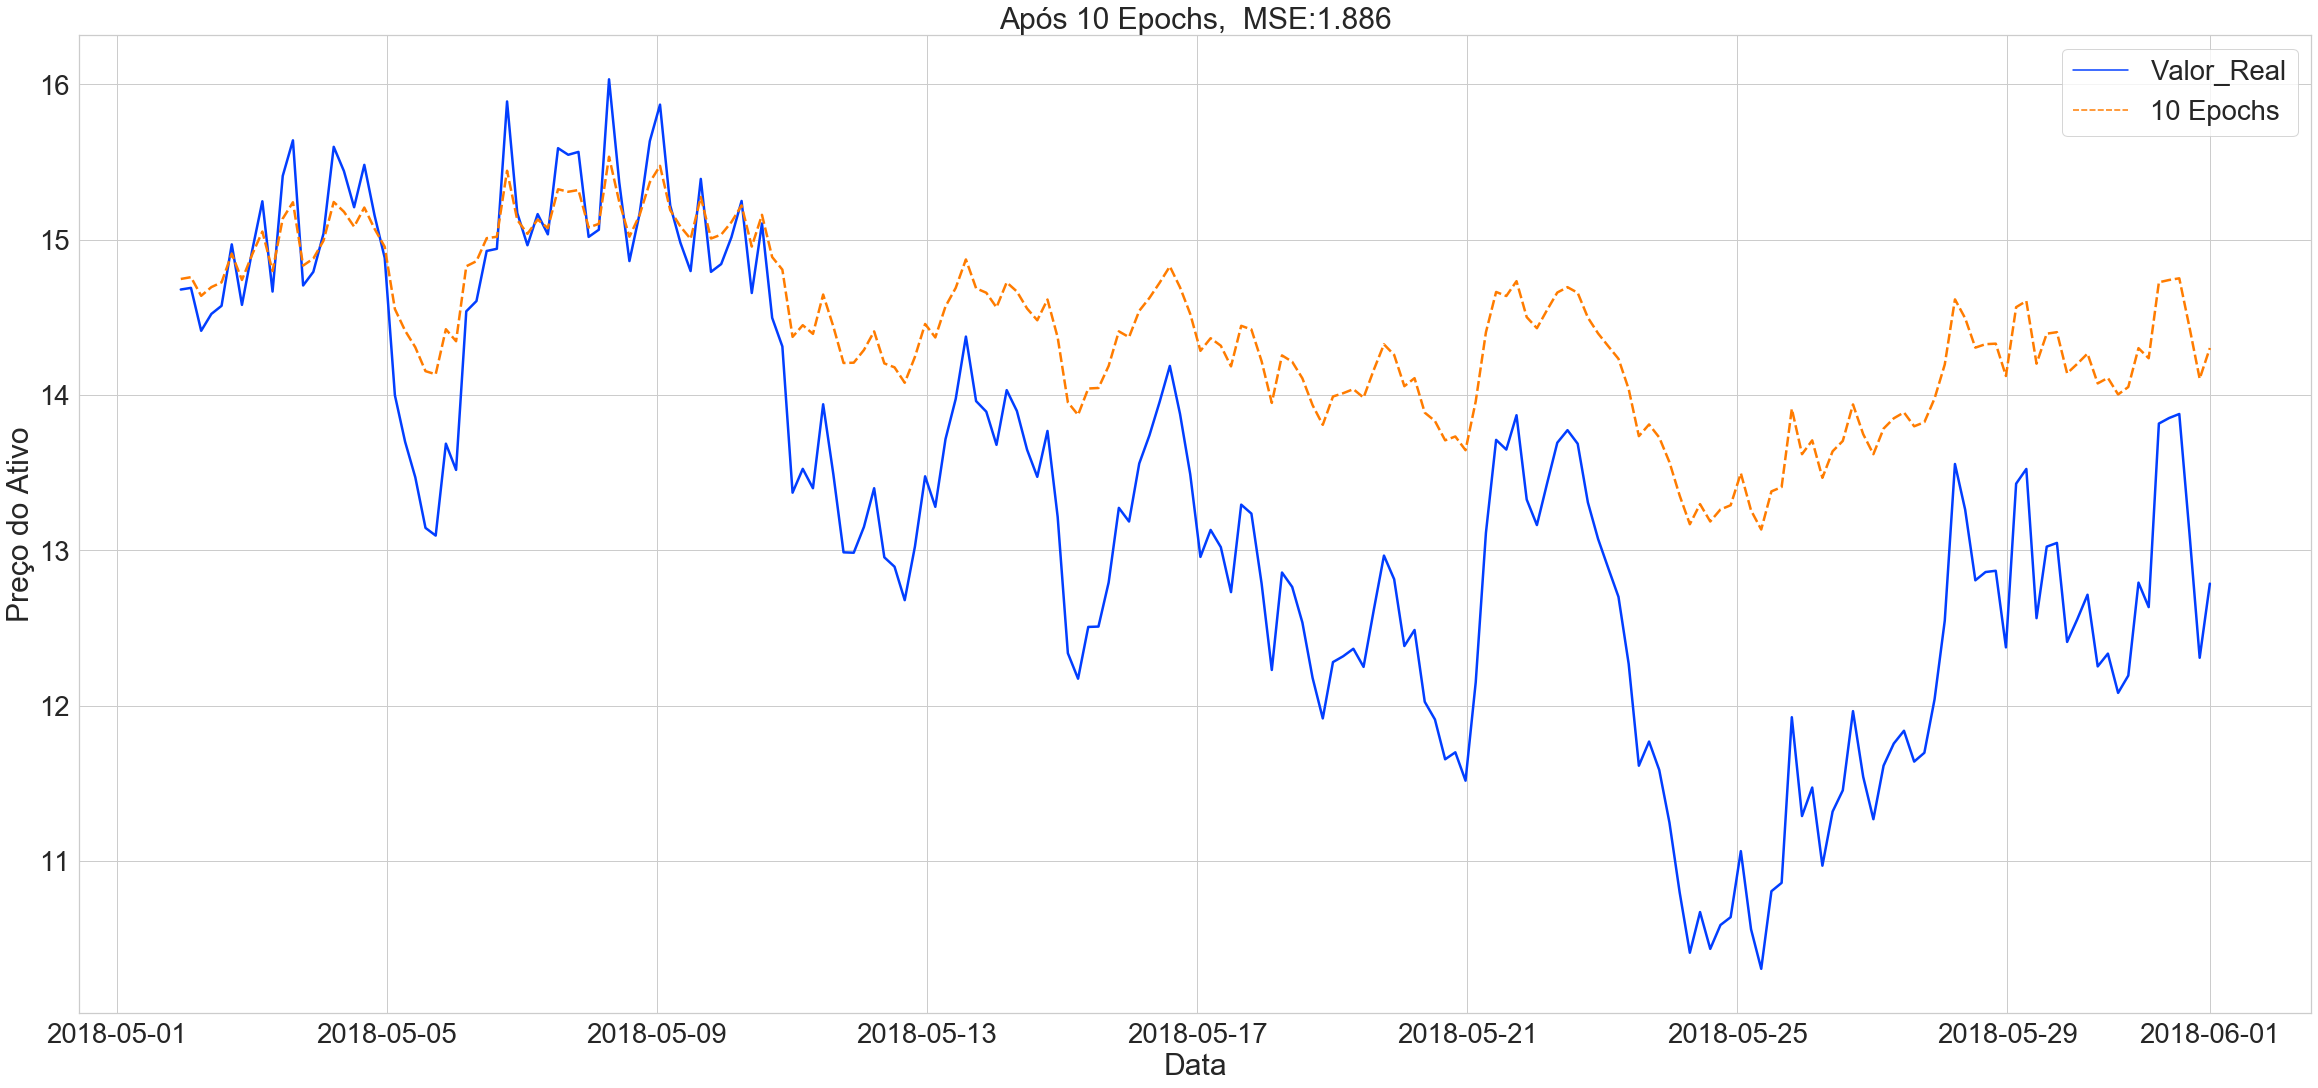

In [39]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "10 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data', 
       ylabel = 'Preço do Ativo', 
       title = f'Após 10 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["10 Epochs"]), 3)}')

[Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 0, 'Data'),
 Text(0.5, 1.0, 'Após 100 Epochs,  MSE:0.421')]

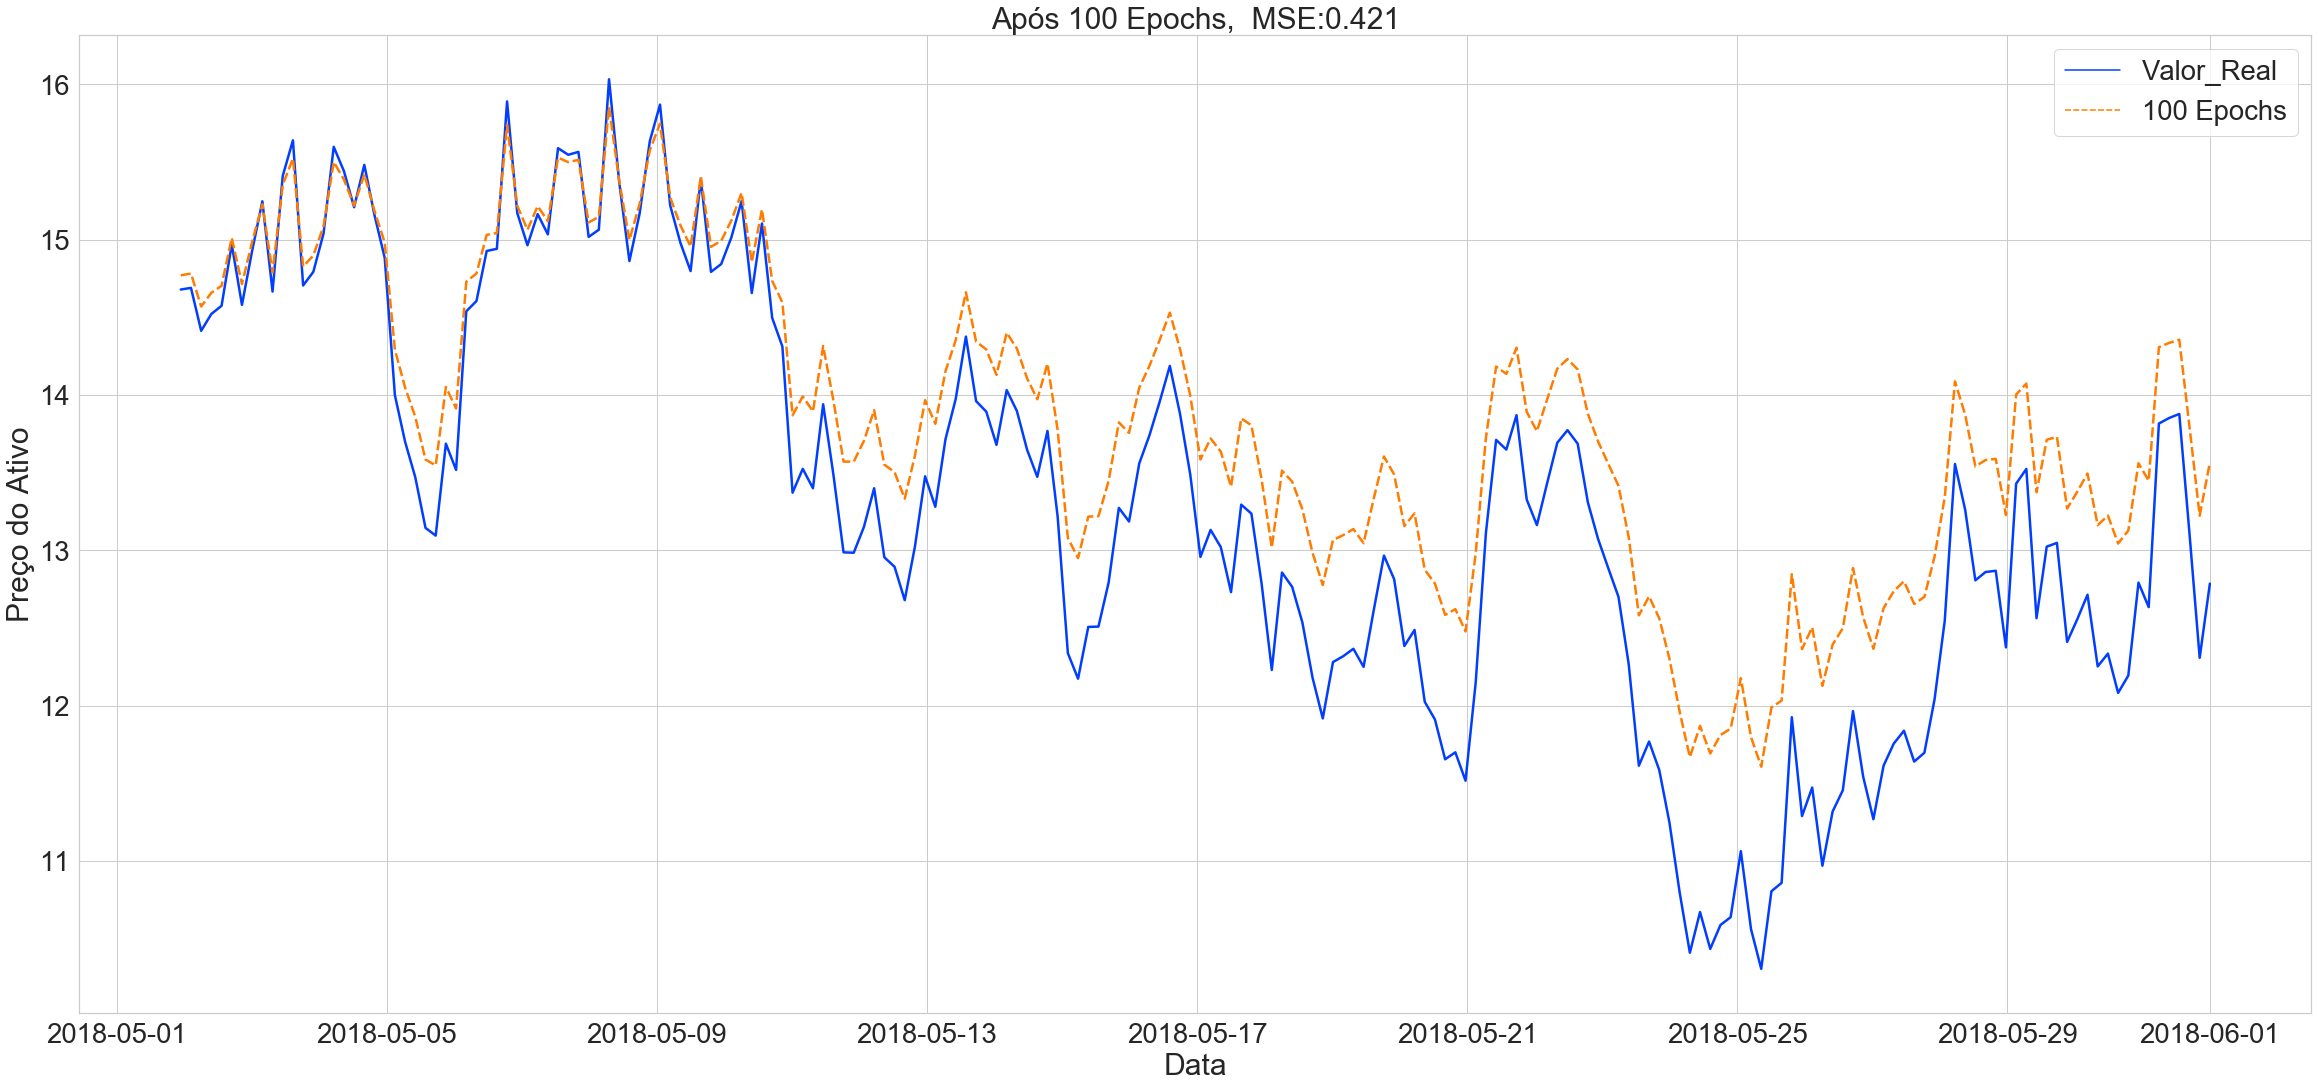

In [40]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "100 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data', 
       ylabel = 'Preço do Ativo', 
       title = f'Após 100 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["100 Epochs"]), 3)}')

[Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 0, 'Data'),
 Text(0.5, 1.0, 'Após 200 Epochs,  MSE:0.52')]

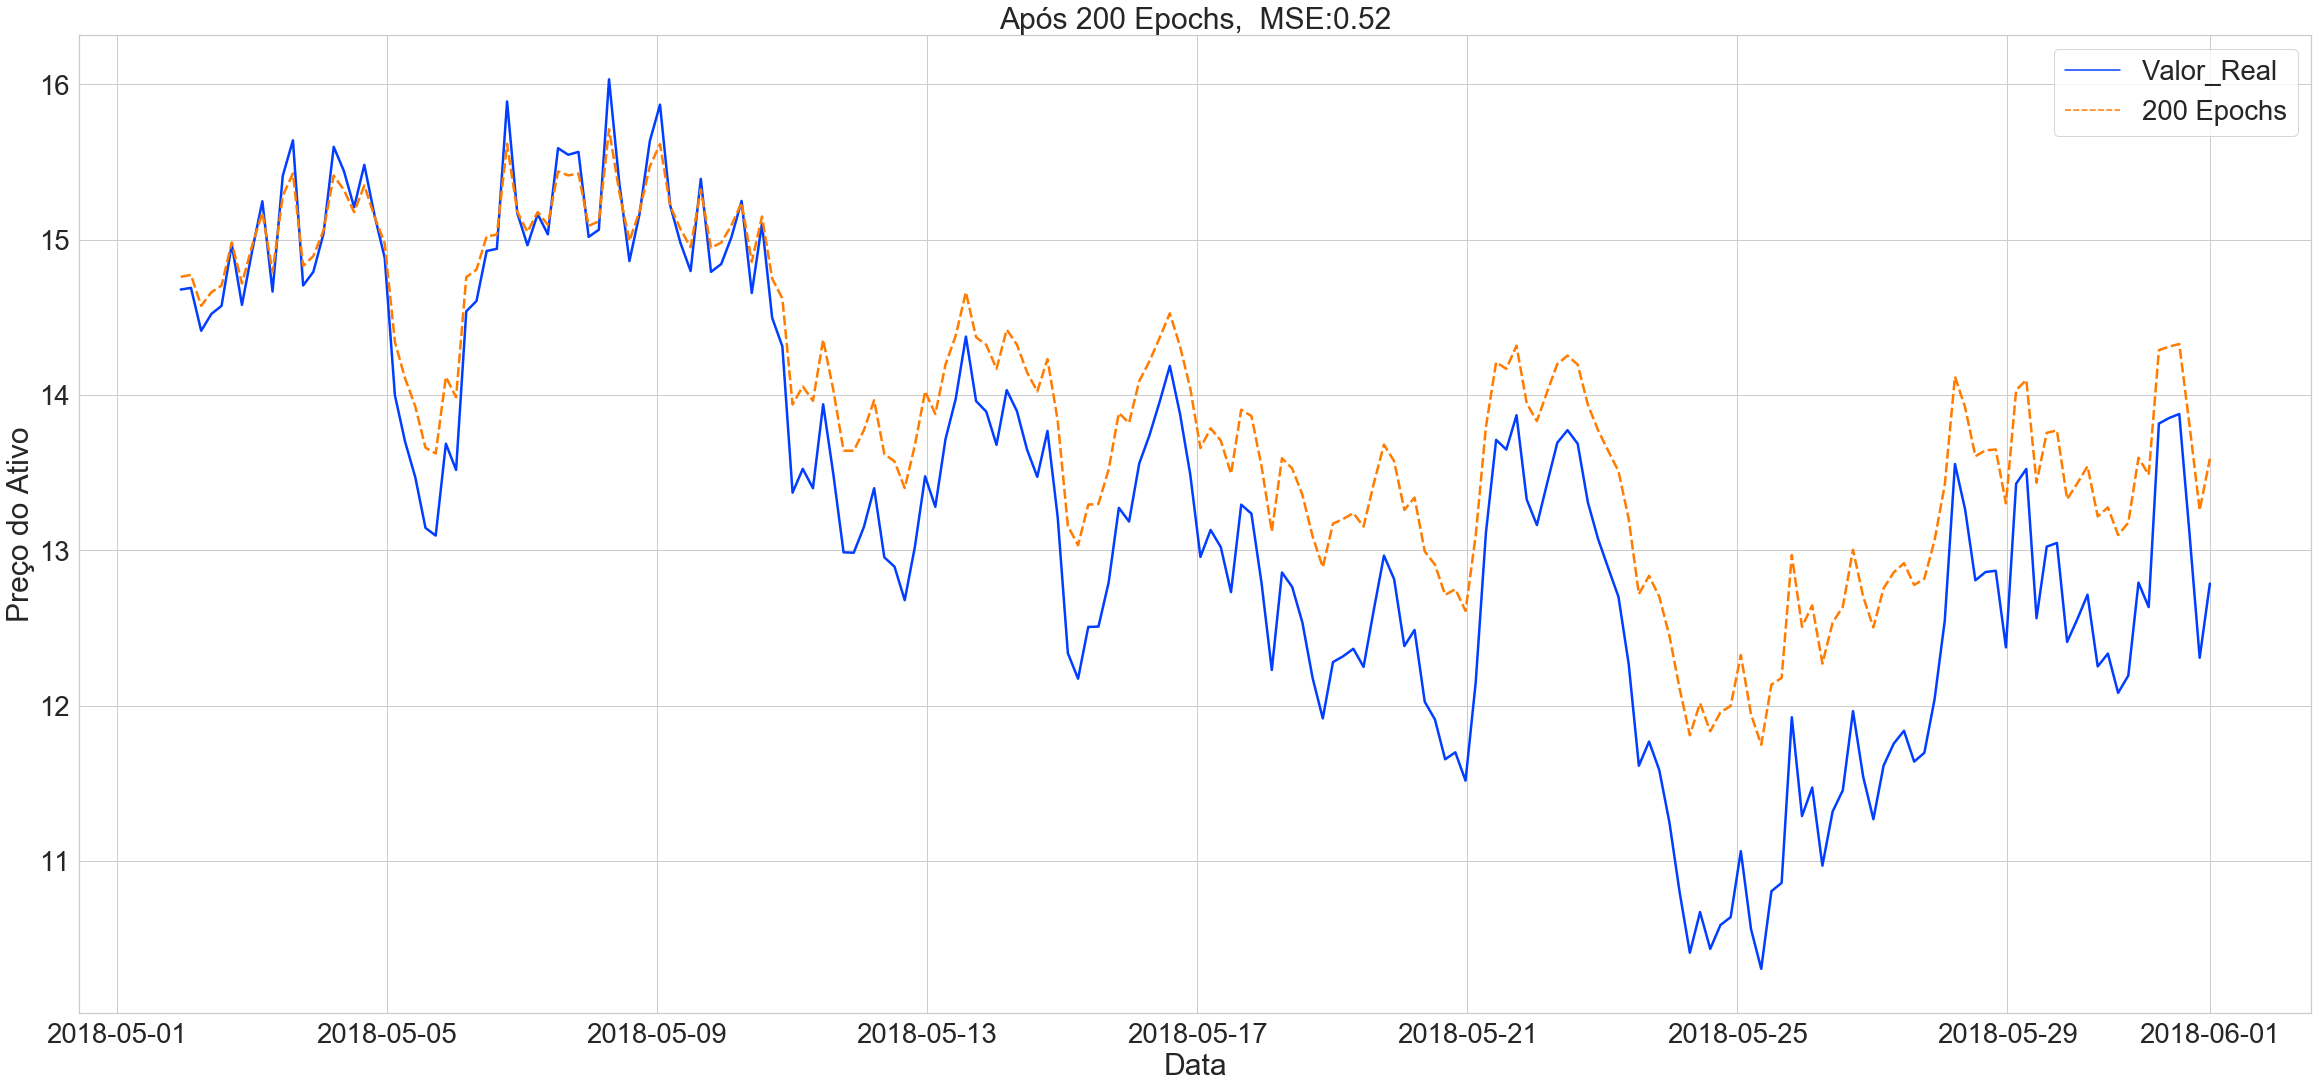

In [41]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "200 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data', 
       ylabel = 'Preço do Ativo', 
       title = f'Após 200 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["200 Epochs"]), 3)}')

[Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 0, 'Data'),
 Text(0.5, 1.0, 'Após 1000 Epochs,  MSE:0.039')]

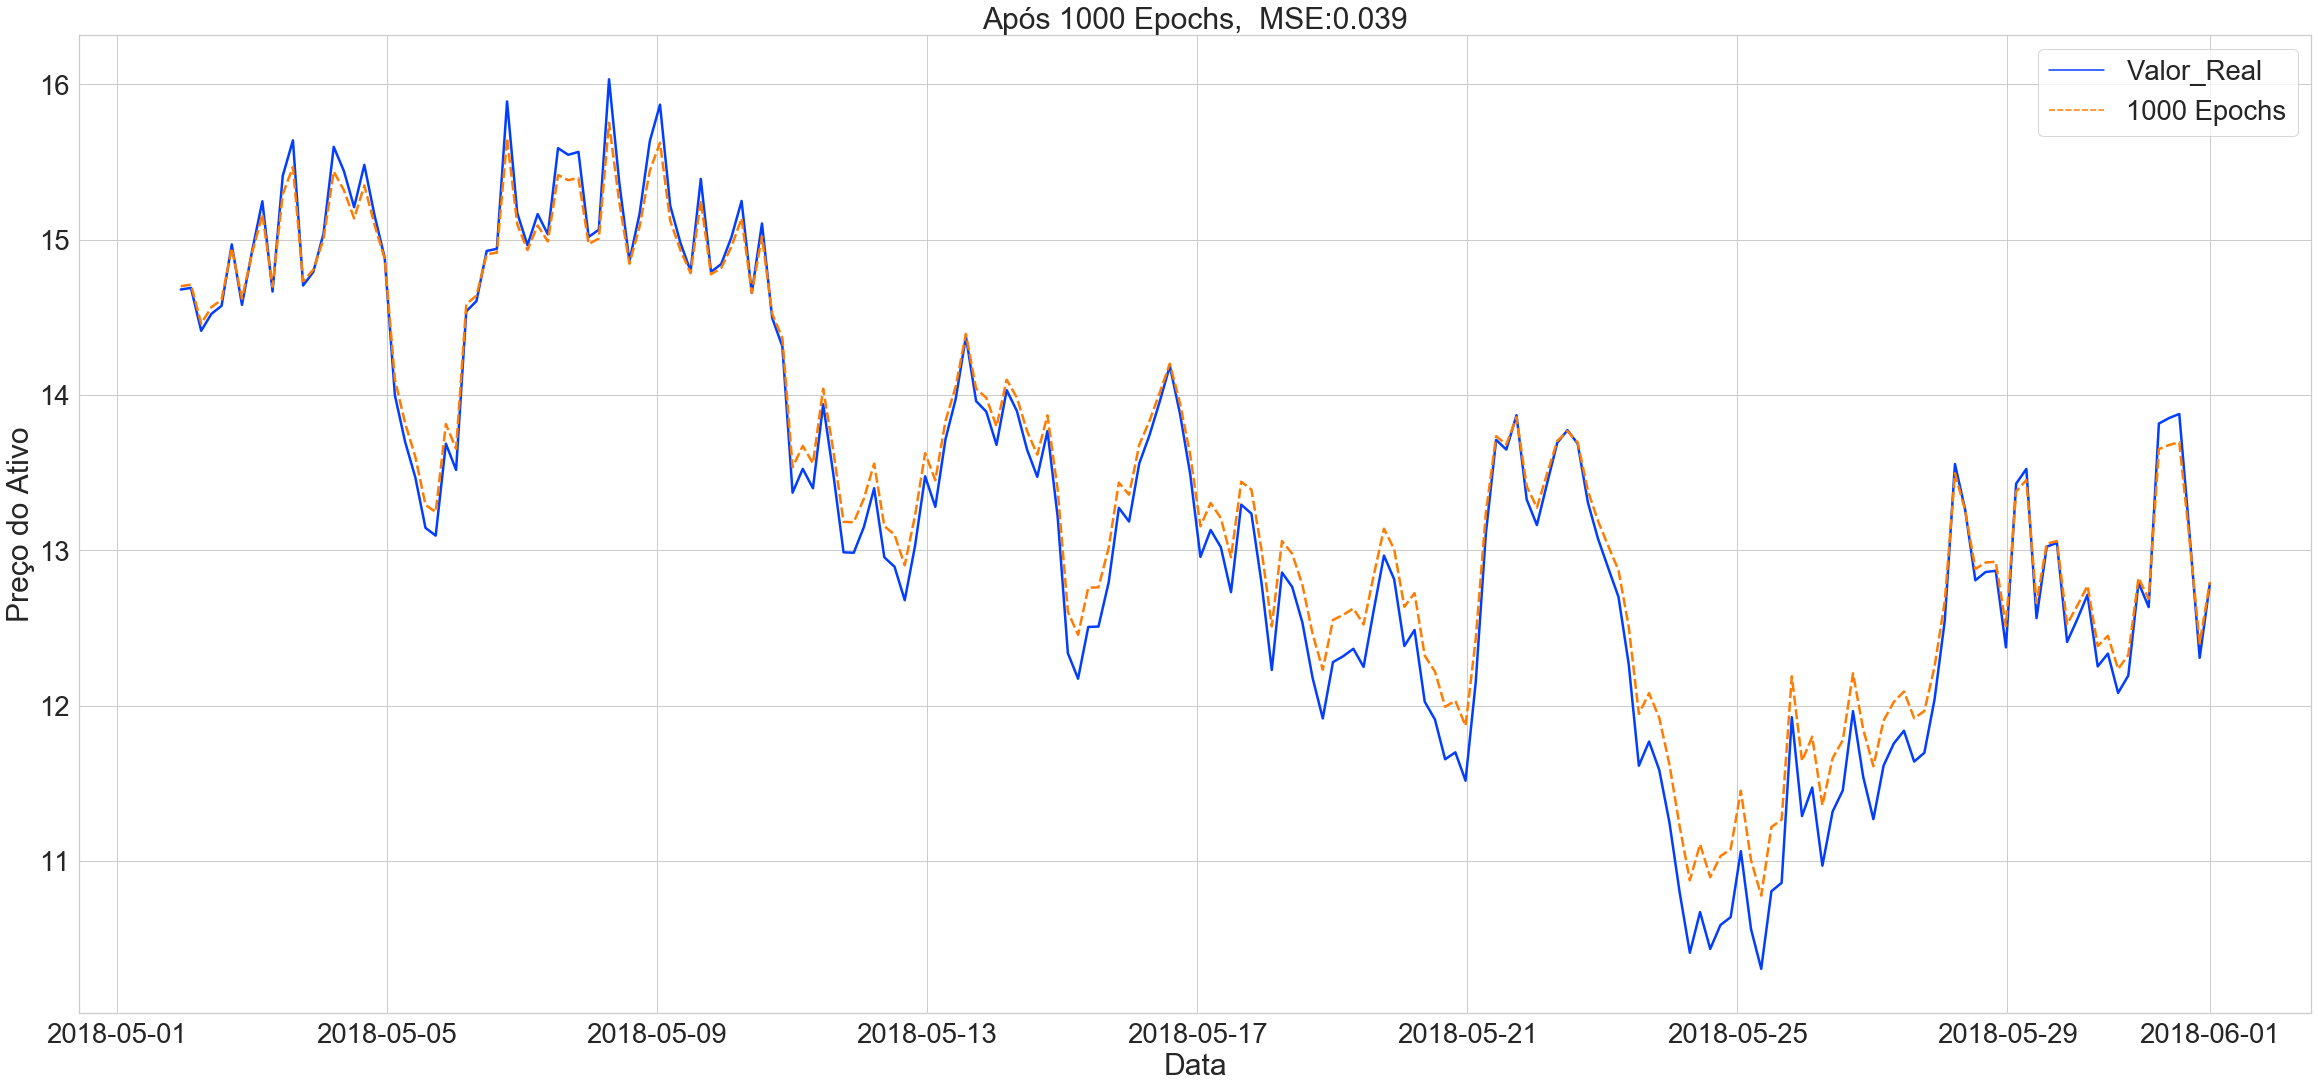

In [42]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "1000 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data', 
       ylabel = 'Preço do Ativo', 
       title = f'Após 1000 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["1000 Epochs"]), 3)}')

[Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 0, 'Data'),
 Text(0.5, 1.0, 'Após 5000 Epochs,  MSE:0.166')]

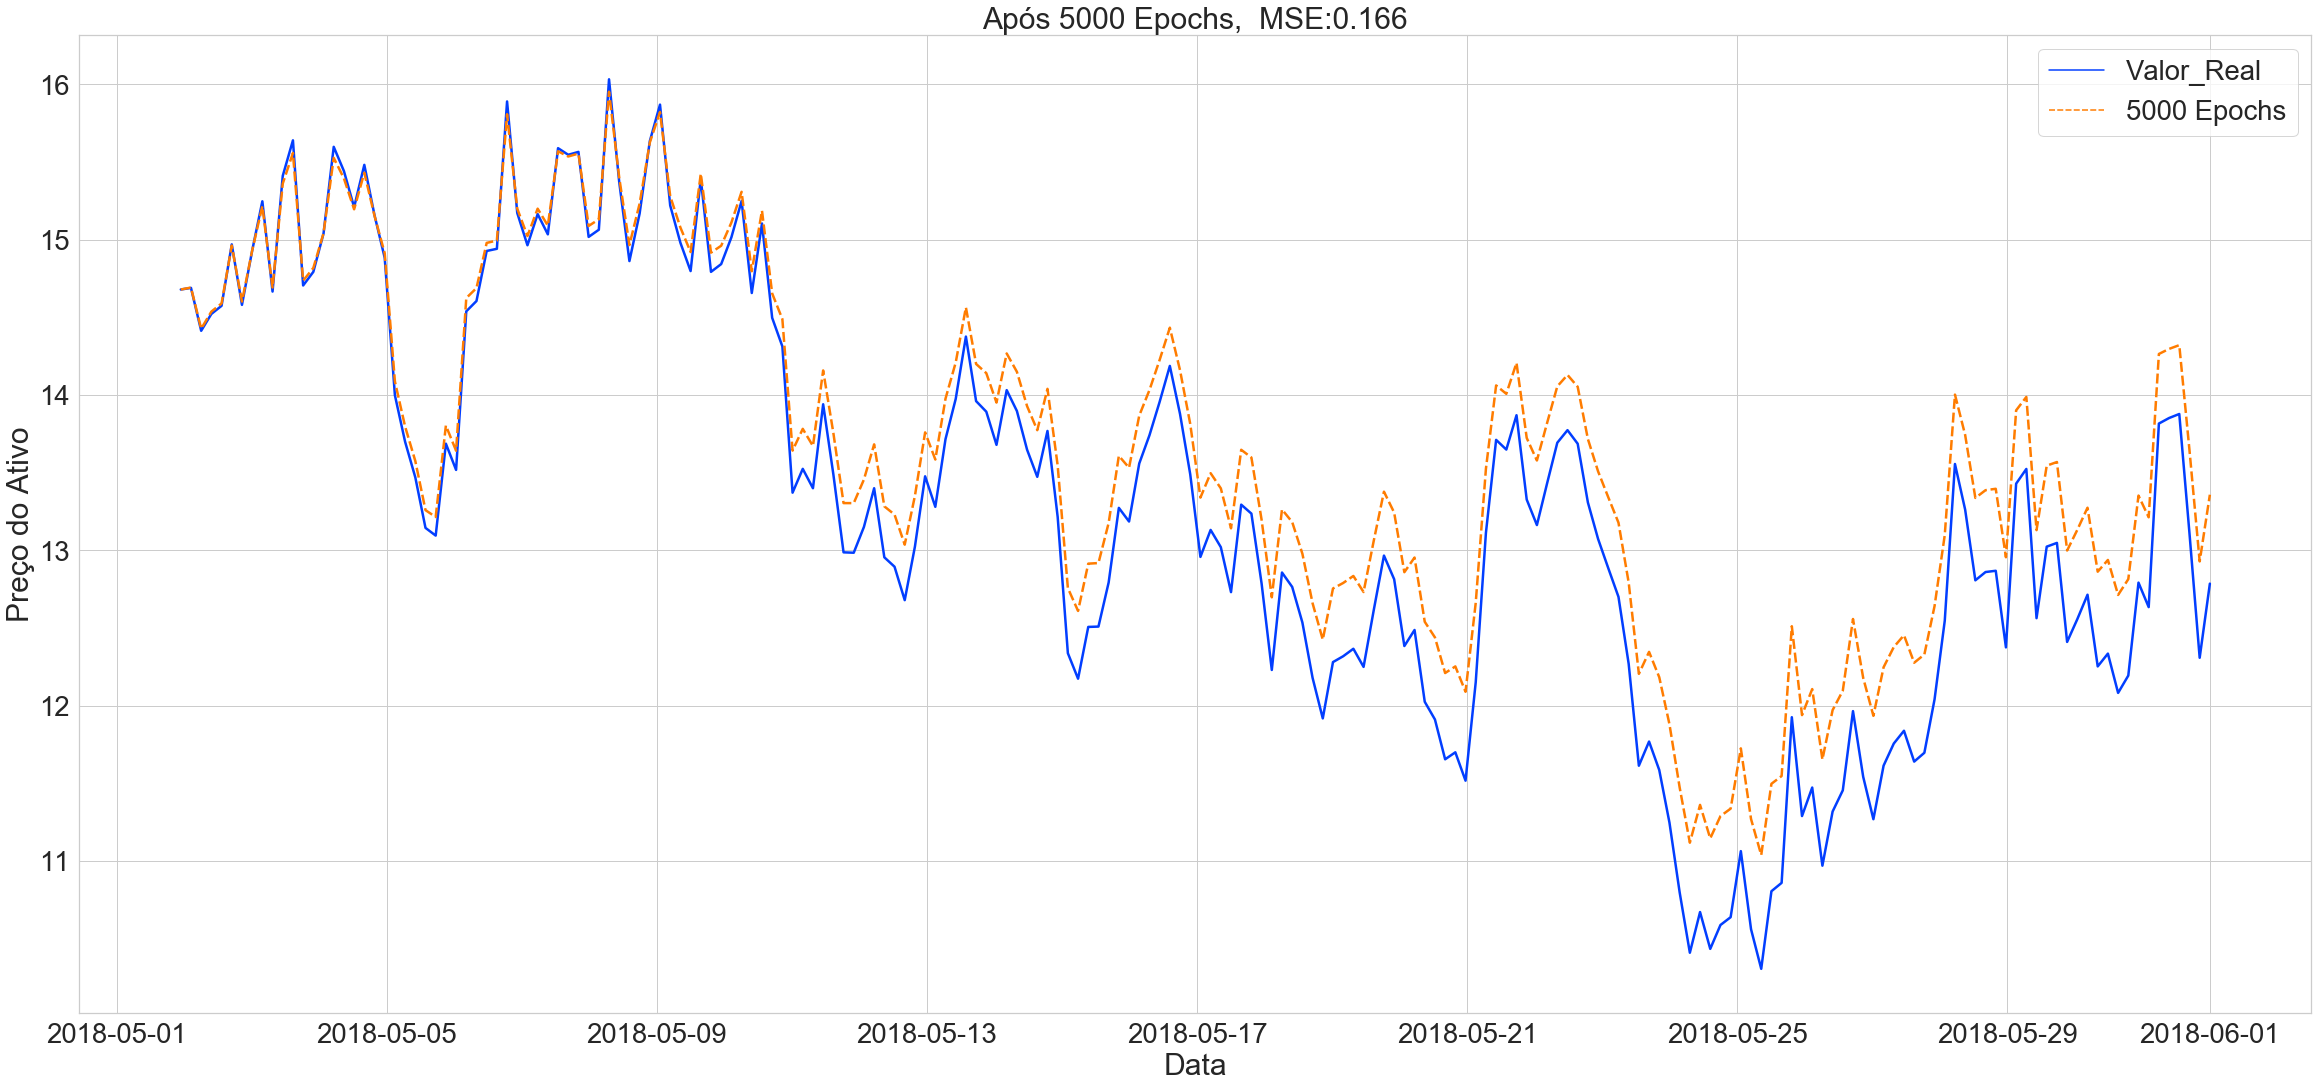

In [43]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "5000 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data', 
       ylabel = 'Preço do Ativo', 
       title = f'Após 5000 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["5000 Epochs"]), 3)}')

## Conclusão

Treinar o modelo por poucas epochs ou por epochs demais afeta negativamente a performance do modelo. A construção de um modelo equilibrado depende do ponto ideal de treinamento, o que requer experimentação.

# Fim